## Mount Google Drive and Set Up Dataset

This section mounts Google Drive to access the dataset file (`CBIS_DDSM.zip`). The ZIP file is copied from Google Drive to the local environment, extracted, and then the original ZIP file is deleted to save storage space. The `cbis_path` variable is set to the location of the extracted dataset.


In [ ]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the dataset ZIP file from Google Drive to the local environment
!cp "/content/drive/My Drive/FYP_Project/CBIS_DDSM.zip" .
# Unzip the dataset quietly (suppress output)
!unzip -qq CBIS_DDSM.zip
# Remove the ZIP file after extraction to save storage space
!rm CBIS_DDSM.zip
# Set the dataset directory path
cbis_path = 'CBIS_DDSM'


## Install Required Libraries

This section installs TensorFlow and imports the necessary libraries for data processing, model building, and evaluation. Libraries such as `numpy`, `matplotlib`, `seaborn`, and `sklearn` are used for numerical operations, data visualization, and machine learning tasks. Specific modules from TensorFlow are imported to facilitate model creation, compilation, and evaluation.


In [ ]:
# Install TensorFlow
!pip install tensorflow -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 140.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 143.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:82: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## Data Loading Functions

### `load_training()`
Loads the training data from the specified path (`train_tensor.npy` and `train_labels.npy`), excluding baseline patches through slicing.

### `load_testing()`
Loads the test data that contains abnormalities and their respective labels, excluding baseline data.

### `remap_class_label()`
Remaps the class labels into two categories: `0` for mass and `1` for calcification. Labels `1` and `2` are mapped to `0` (mass), while labels `3` and `4` are mapped to `1` (calcification).


In [ ]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'train_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'train_labels.npy'))[1::2]
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_class_label(l):
    """
    Remap the labels to 0->mass 1->calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

## Load and Preprocess Data

This section loads the training and testing images using the `load_training()` and `load_testing()` functions. The following steps are performed:

- Display the size of the training and testing datasets.
- Compute the width and height of the images.
- Remap the labels to `0` for mass and `1` for calcification.
- Reshape the images to include an additional dimension for grayscale.
- Normalize pixel values from a 16-bit scale (0-65535) to a floating-point scale (0-1).
- Shuffle the training dataset, which was originally sorted by label.


In [ ]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
num_of_train_img = train_images.shape[0]
num_of_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (num_of_train_img, num_of_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Remap labels
train_labels = np.array([remap_class_label(l) for l in train_labels])
test_labels = np.array([remap_class_label(l) for l in test_labels])

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((num_of_train_img, img_w, img_h, 1))
test_images = test_images.reshape((num_of_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to float (0-1)
train_images = train_images.astype('uint16') / 65535
test_images = test_images.astype('uint16') / 65535

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(num_of_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

Train size: 2676 	 Test size: 336
Image size: 150x150


## Create Image Data Generators and Visualization

In this section, an image data generator is created for training images, with a validation split of 20%. The generator is then fitted on the training images and used to create separate generators for training and validation subsets.

Visualization steps include:

- Displaying a single image from the dataset along with its label to verify the data format.
- Displaying a grid of 12 images from the training set, each with its corresponding label ("Mass" or "Calcification").


In [ ]:
# Create a generator for training images
train_data_generate = ImageDataGenerator(
    validation_split=0.2
)

# Fit the generator with some images
train_data_generate.fit(train_images)

# Split train images into actual training and validation
train_generator = train_data_generate.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_data_generate.flow(train_images, train_labels, batch_size=32, subset='validation')

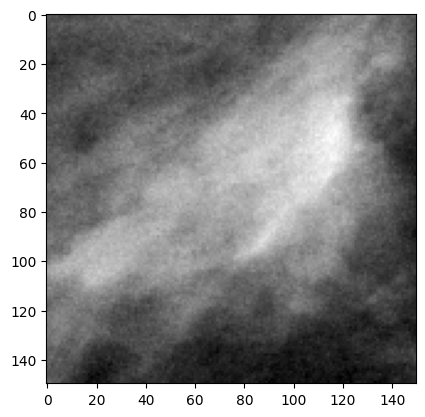

Label: 0


In [ ]:
# Visualize one image from the dataset and its label, just to make sure the data format is correct

idx = 0

plt.imshow(train_images[idx][:,:,0], cmap='gray')
plt.show()

print("Label: " + str(train_labels[idx]))

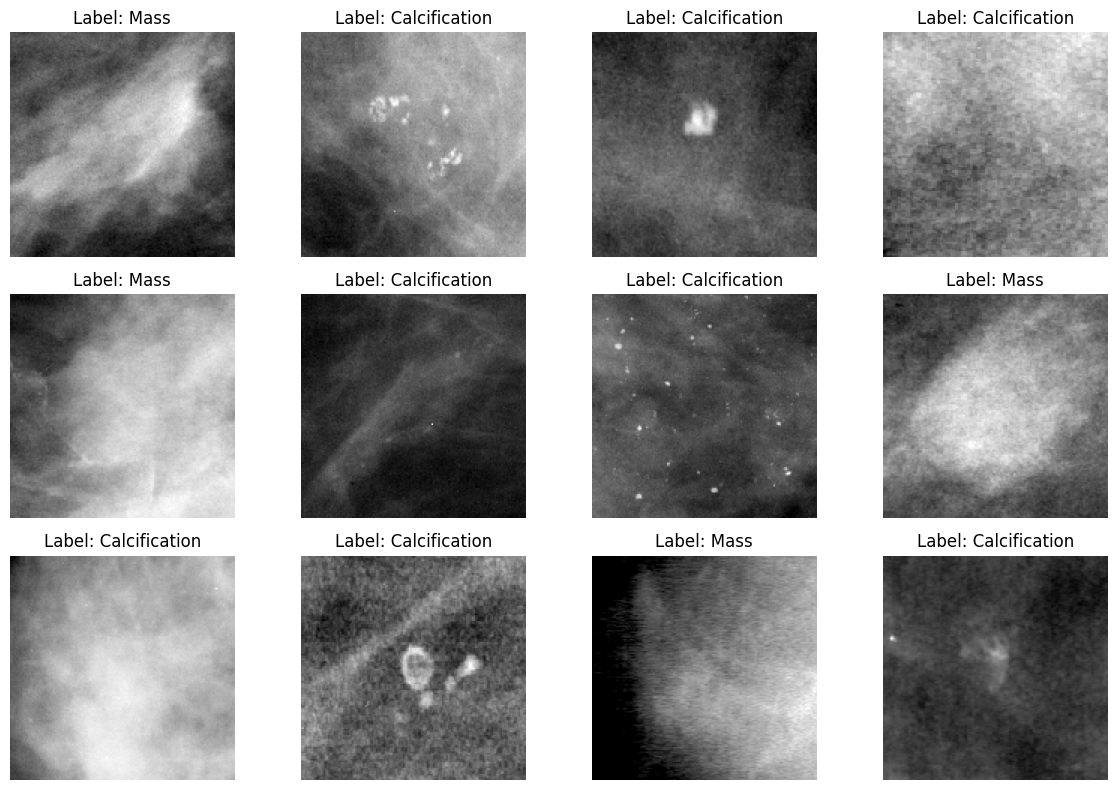

In [ ]:
# Plot a grid of 12 images with their labels
num_images = 12
plt.figure(figsize=(12, 8))

for i in range(num_images):
    plt.subplot(3, 4, i + 1)
    plt.imshow(train_images[i][:,:,0], cmap='gray')
    label = 'Calcification' if train_labels[i] == 1 else 'Mass'
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Plot Class Distribution

The training labels are converted into a Pandas Series and mapped to class names ("Mass" and "Calcification"). A count plot is then generated to visualize the distribution of classes in the training set.


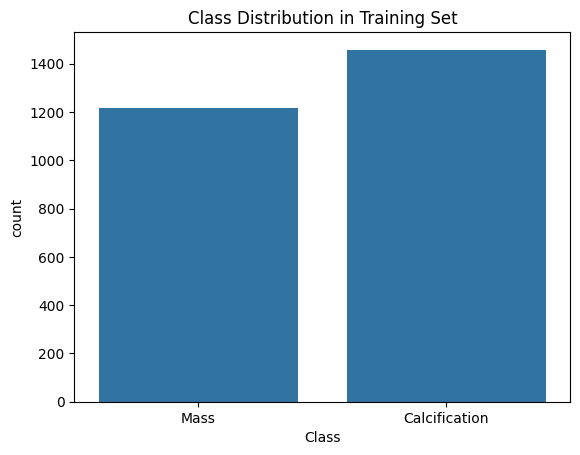

In [ ]:
# Convert to pandas Series for plotting
labels_series = pd.Series(train_labels, name="Class")
labels_series = labels_series.map({0: "Mass", 1: "Calcification"})

# Plot class distribution
sns.countplot(x=labels_series)
plt.title("Class Distribution in Training Set")
plt.show()


In [ ]:
model_0 = models.Sequential()
model_0.add(layers.Input(shape=(150, 150, 1)))
model_0.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_0.add(layers.MaxPooling2D((2, 2)))
model_0.add(layers.Flatten())
model_0.add(layers.Dense(16, activation='relu'))
model_0.add(layers.Dense(1, activation='sigmoid'))

model_0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │     1,327,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345,953 (5.13 MB)

 Trainable params: 1,345,953 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback
checkpoint = ModelCheckpoint('model_0_MC_best.keras',
    monitor='val_loss', mode='min', verbose=1,
    save_best_only=True, save_freq='epoch'
)

# Compile
model_0.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train (using fit instead of fit_generator)
history_0 = model_0.fit(
    train_generator,
    steps_per_epoch=int(0.8 * num_of_train_img) // 32,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

# Save the final model after training
model_0.save('model_0_MC_end.keras')

# Optionally copy the model to Google Drive
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5488 - loss: 0.6916
Epoch 1: val_loss improved from inf to 0.69175, saving model to model_0_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5489 - loss: 0.6916 - val_accuracy: 0.5159 - val_loss: 0.6918
Epoch 2/100
 1/66 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6207 - loss: 0.6867
Epoch 2: val_loss improved from 0.69175 to 0.69175, saving model to model_0_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6207 - loss: 0.6867 - val_accuracy: 0.5159 - val_loss: 0.6918
Epoch 3/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5595 - loss: 0.7698
Epoch 3: val_loss improved from 0.69175 to 0.69124, saving model to model_0_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5589 - loss: 0.7672 - val_accuracy: 0.5159 - val_loss: 0.6912
Epoch 4/100
 1/66 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7188 - loss: 0.6771
Epoch 4: val_loss improved from 0.69124 to 

In [ ]:
# History of accuracy and loss
tra_loss_0 = history_0.history['loss']
tra_acc_0 = history_0.history['accuracy']
val_loss_0 = history_0.history['val_loss']
val_acc_0 = history_0.history['val_accuracy']

# Total epochs
epochs_0 = range(1, len(tra_acc_0) + 1)
end_epoch_0 = len(tra_acc_0)

# Epoch of min validation loss
opt_epoch_0 = val_loss_0.index(min(val_loss_0)) + 1

# Validation loss/accuracy at end and optimal epoch
end_val_loss_0 = val_loss_0[-1]
end_val_acc_0 = val_acc_0[-1]
opt_val_loss_0 = val_loss_0[opt_epoch_0 - 1]
opt_val_acc_0 = val_acc_0[opt_epoch_0 - 1]

# Load the best saved model
opt_model_0 = models.load_model('model_0_MC_best.keras')

# Evaluate on test data
test_loss_0, test_acc_0 = model_0.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_0, opt_test_acc_0 = opt_model_0.evaluate(test_images, test_labels, verbose=False)

# Predict classes
opt_pred_0 = opt_model_0.predict(test_images)
pred_classes_0 = (opt_pred_0 > 0.5).astype(int)

from sklearn.metrics import classification_report

print("Model 0\n")
print(f"Epoch [end]: {end_epoch_0}")
print(f"Epoch [opt]: {opt_epoch_0}")
print(f"Valid accuracy [end]: {end_val_acc_0:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_0:.4f}")
print(f"Test accuracy [end]:  {test_acc_0:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_0:.4f}")
print(f"Valid loss [end]: {end_val_loss_0:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_0:.4f}")
print(f"Test loss [end]:  {test_loss_0:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_0:.4f}")

print(classification_report(test_labels.flatten(), pred_classes_0.flatten(), digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Model 0

Epoch [end]: 100
Epoch [opt]: 56
Valid accuracy [end]: 0.7925
Valid accuracy [opt]: 0.7963
Test accuracy [end]:  0.7500
Test accuracy [opt]:  0.7560
Valid loss [end]: 0.5646
Valid loss [opt]: 0.4528
Test loss [end]:  0.6560
Test loss [opt]:  0.4921
              precision    recall  f1-score   support

           0     0.8129    0.7039    0.7545       179
           1     0.7072    0.8153    0.7574       157

    accuracy                         0.7560       336
   macro avg     0.7600    0.7596    0.7559       336
weighted avg     0.7635    0.7560    0.7558       336



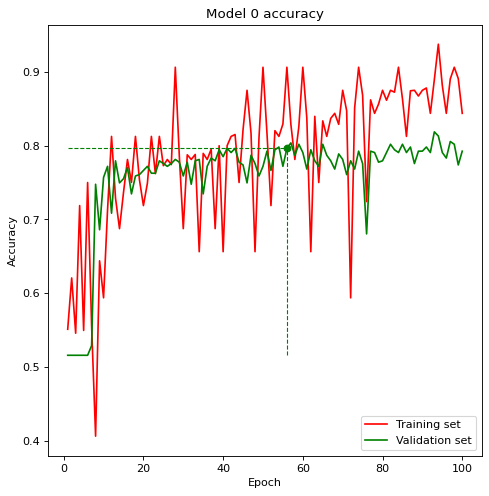

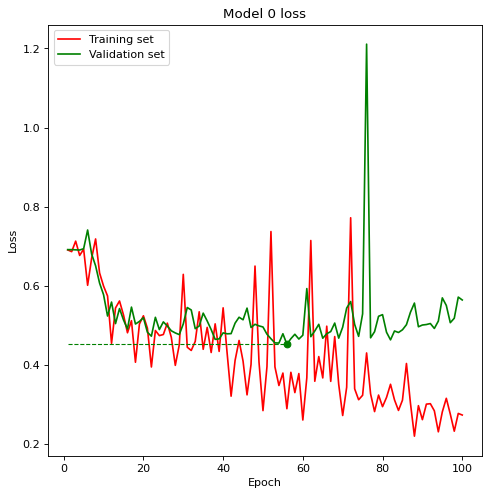

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_acc_0, 'r', label='Training set')
plt.plot(epochs_0, val_acc_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_acc_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_acc_0), opt_val_acc_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 0 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_0, tra_loss_0, 'r', label='Training set')
plt.plot(epochs_0, val_loss_0, 'g', label='Validation set')
plt.plot(opt_epoch_0, val_loss_0[opt_epoch_0-1], 'go')
plt.vlines(opt_epoch_0, min(val_loss_0), opt_val_loss_0, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_0, 1, opt_epoch_0, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 1

model_1 = models.Sequential()
model_1.add(layers.Input(shape=(150, 150, 1)))
model_1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(16, activation='relu'))
model_1.add(layers.Dropout(0.5))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │     1,327,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345,953 (5.13 MB)

 Trainable params: 1,345,953 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_1_MC_best.keras',
    monitor='val_loss', mode='min', verbose=1,
    save_best_only=True, save_freq='epoch'
)

# Compile the model
model_1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_1 = model_1.fit(
    train_generator,
    steps_per_epoch=int(0.8*num_of_train_img) // 32,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint],
    shuffle=True,
    verbose=1,
    initial_epoch=0
)

# Save final model
models.save_model(model_1, 'model_1_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"


Epoch 1/100
64/66 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4960 - loss: 0.8398
Epoch 1: val_loss improved from inf to 0.72008, saving model to model_1_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.4971 - loss: 0.8351 - val_accuracy: 0.4206 - val_loss: 0.7201
Epoch 2/100
 1/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4688 - loss: 0.6970
Epoch 2: val_loss improved from 0.72008 to 0.69252, saving model to model_1_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4688 - loss: 0.6970 - val_accuracy: 0.4841 - val_loss: 0.6925
Epoch 3/100
56/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5306 - loss: 0.7061
Epoch 3: val_loss improved from 0.69252 to 0.68574, saving model to model_1_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5301 - loss: 0.7054 - val_accuracy: 0.5832 - val_loss: 0.6857
Epoch 4/100
 1/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4688 - loss: 0.6995
Epoch 4: val_loss did not improve from 0.68574


In [ ]:
# History of accuracy and loss
tra_loss_1 = history_1.history['loss']
tra_acc_1 = history_1.history['accuracy']
val_loss_1 = history_1.history['val_loss']
val_acc_1 = history_1.history['val_accuracy']

# Total number of epochs training
epochs_1 = range(1, len(tra_acc_1) + 1)
end_epoch_1 = len(tra_acc_1)

# Epoch when reached the validation loss minimum
opt_epoch_1 = val_loss_1.index(min(val_loss_1)) + 1

# Loss and accuracy on the validation set
end_val_loss_1 = val_loss_1[-1]
end_val_acc_1 = val_acc_1[-1]
opt_val_loss_1 = val_loss_1[opt_epoch_1 - 1]
opt_val_acc_1 = val_acc_1[opt_epoch_1 - 1]

# Load best model checkpoint (make sure filename is correct)
opt_model_1 = models.load_model('model_1_MC_best.keras')

# Evaluate on test set
test_loss_1, test_acc_1 = model_1.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_1, opt_test_acc_1 = opt_model_1.evaluate(test_images, test_labels, verbose=False)

# Predict classes on test set
opt_pred_1 = opt_model_1.predict(test_images)
pred_classes_1 = np.rint(opt_pred_1).flatten()

print("Model 1\n")
print("Epoch [end]: %d" % end_epoch_1)
print("Epoch [opt]: %d" % opt_epoch_1)
print("Valid accuracy [end]: %.4f" % end_val_acc_1)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_1)
print("Test accuracy [end]:  %.4f" % test_acc_1)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_1)
print("Valid loss [end]: %.4f" % end_val_loss_1)
print("Valid loss [opt]: %.4f" % opt_val_loss_1)
print("Test loss [end]:  %.4f" % test_loss_1)
print("Test loss [opt]:  %.4f" % opt_test_loss_1)

print(classification_report(test_labels, pred_classes_1, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Model 1

Epoch [end]: 100
Epoch [opt]: 90
Valid accuracy [end]: 0.7738
Valid accuracy [opt]: 0.8112
Test accuracy [end]:  0.7917
Test accuracy [opt]:  0.7798
Valid loss [end]: 0.4832
Valid loss [opt]: 0.4473
Test loss [end]:  0.5106
Test loss [opt]:  0.5264
              precision    recall  f1-score   support

           0     0.7869    0.8045    0.7956       179
           1     0.7712    0.7516    0.7613       157

    accuracy                         0.7798       336
   macro avg     0.7791    0.7780    0.7784       336
weighted avg     0.7796    0.7798    0.7796       336



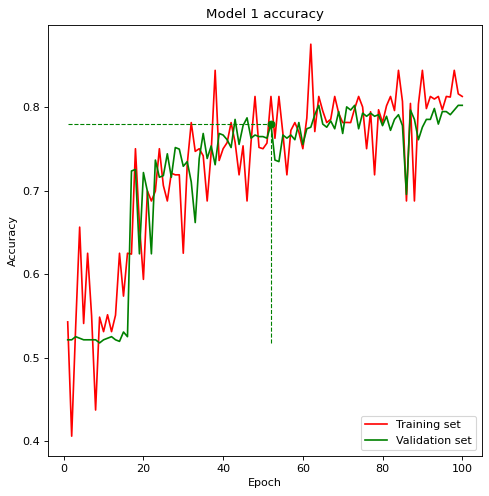

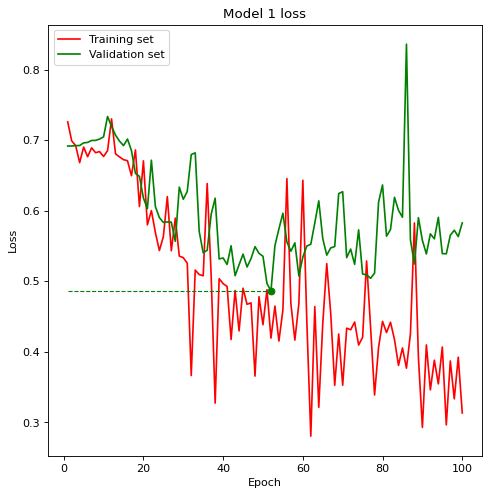

In [ ]:

# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_acc_1, 'r', label='Training set')
plt.plot(epochs_1, val_acc_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_acc_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_acc_1), opt_val_acc_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_1, tra_loss_1, 'r', label='Training set')
plt.plot(epochs_1, val_loss_1, 'g', label='Validation set')
plt.plot(opt_epoch_1, val_loss_1[opt_epoch_1-1], 'go')
plt.vlines(opt_epoch_1, min(val_loss_1), opt_val_loss_1, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_1, 1, opt_epoch_1, linestyle="dashed", color='g', linewidth=1)
plt.legend();


In [ ]:
# Create a generator for training images
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=32, subset='validation')


In [ ]:
# Model 2

model_2 = models.Sequential()
model_2.add(layers.Input(shape=(150, 150, 1)))
model_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │     1,327,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,345,953 (5.13 MB)

 Trainable params: 1,345,953 (5.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callback for checkpointing
checkpoint = ModelCheckpoint('model_2_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_2 = model_2.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 32,
        epochs=100,
        validation_data=validation_generator,
        callbacks=[checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save final model
models.save_model(model_2, 'model_2_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5166 - loss: 0.9657
Epoch 1: val_loss improved from inf to 0.69264, saving model to model_2_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - accuracy: 0.5169 - loss: 0.9627 - val_accuracy: 0.5215 - val_loss: 0.6926
Epoch 2/100
 1/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5625 - loss: 0.6916

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.69264 to 0.69263, saving model to model_2_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5625 - loss: 0.6916 - val_accuracy: 0.5215 - val_loss: 0.6926
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5648 - loss: 0.6910
Epoch 3: val_loss did not improve from 0.69263
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5645 - loss: 0.6910 - val_accuracy: 0.5215 - val_loss: 0.6941
Epoch 4/100
 1/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5938 - loss: 0.6945
Epoch 4: val_loss did not improve from 0.69263
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5938 - loss: 0.6945 - val_accuracy: 0.5215 - val_loss: 0.6941
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5512 - loss: 0.6926
Epoch 5: val_loss improved from 0.69263 to 0.69056, saving model to model_2_MC_best.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5512 - loss: 0.6926 - val_accuracy: 0.5215 - val_loss: 0.6906
Epoc

In [ ]:
# History of accuracy and loss
tra_loss_2 = history_2.history['loss']
tra_acc_2 = history_2.history['accuracy']
val_loss_2 = history_2.history['val_loss']
val_acc_2 = history_2.history['val_accuracy']

# Total number of epochs training
epochs_2 = range(1, len(tra_acc_2) + 1)
end_epoch_2 = len(tra_acc_2)

# Epoch when reached the validation loss minimum
opt_epoch_2 = val_loss_2.index(min(val_loss_2)) + 1

# Loss and accuracy on the validation set
end_val_loss_2 = val_loss_2[-1]
end_val_acc_2 = val_acc_2[-1]
opt_val_loss_2 = val_loss_2[opt_epoch_2 - 1]
opt_val_acc_2 = val_acc_2[opt_epoch_2 - 1]

# Load best model checkpoint (make sure filename is correct)
opt_model_2 = models.load_model('model_2_MC_best.keras')

# Evaluate on test set
test_loss_2, test_acc_2 = model_2.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_2, opt_test_acc_2 = opt_model_2.evaluate(test_images, test_labels, verbose=False)

# Predict classes on test set
opt_pred_2 = opt_model_2.predict(test_images)
pred_classes_2 = np.rint(opt_pred_2).flatten()

print("Model 2\n")
print("Epoch [end]: %d" % end_epoch_2)
print("Epoch [opt]: %d" % opt_epoch_2)
print("Valid accuracy [end]: %.4f" % end_val_acc_2)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_2)
print("Test accuracy [end]:  %.4f" % test_acc_2)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_2)
print("Valid loss [end]: %.4f" % end_val_loss_2)
print("Valid loss [opt]: %.4f" % opt_val_loss_2)
print("Test loss [end]:  %.4f" % test_loss_2)
print("Test loss [opt]:  %.4f" % opt_test_loss_2)

print(classification_report(test_labels, pred_classes_2, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Model 2

Epoch [end]: 100
Epoch [opt]: 82
Valid accuracy [end]: 0.7664
Valid accuracy [opt]: 0.7495
Test accuracy [end]:  0.7560
Test accuracy [opt]:  0.7649
Valid loss [end]: 0.5252
Valid loss [opt]: 0.5033
Test loss [end]:  0.6665
Test loss [opt]:  0.5166
              precision    recall  f1-score   support

           0     0.7500    0.8380    0.7916       179
           1     0.7868    0.6815    0.7304       157

    accuracy                         0.7649       336
   macro avg     0.7684    0.7598    0.7610       336
weighted avg     0.7672    0.7649    0.7630       336



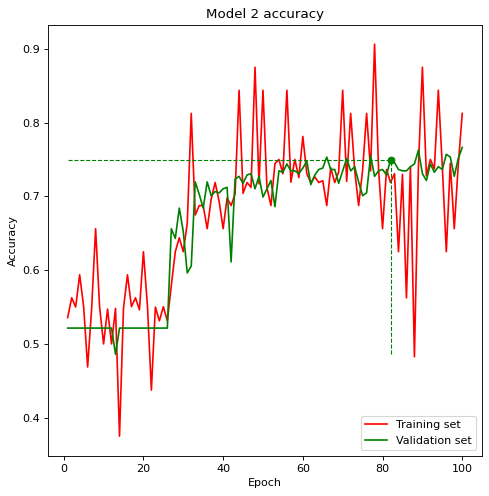

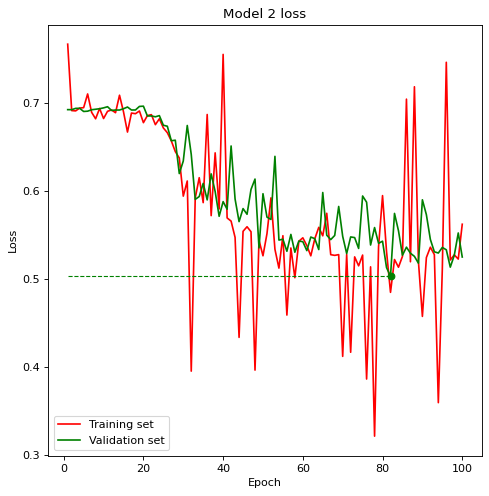

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_acc_2, 'r', label='Training set')
plt.plot(epochs_2, val_acc_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_acc_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_acc_2), opt_val_acc_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_2, tra_loss_2, 'r', label='Training set')
plt.plot(epochs_2, val_loss_2, 'g', label='Validation set')
plt.plot(opt_epoch_2, val_loss_2[opt_epoch_2-1], 'go')
plt.vlines(opt_epoch_2, min(val_loss_2), opt_val_loss_2, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_2, 1, opt_epoch_2, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 3

model_3 = models.Sequential()
model_3.add(layers.Input(shape=(150, 150, 1)))
model_3.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(1, activation='sigmoid'))

model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │     1,183,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,481 (4.87 MB)

 Trainable params: 1,276,481 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Increase batch size
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=40, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_3_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_3 = model_3.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save final model
models.save_model(model_3, 'model_3_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5355 - loss: 1.1207
Epoch 1: val_loss improved from inf to 0.69257, saving model to model_3_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 604ms/step - accuracy: 0.5348 - loss: 1.1062 - val_accuracy: 0.5215 - val_loss: 0.6926
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5312 - loss: 0.6923

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.69257 to 0.69243, saving model to model_3_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5312 - loss: 0.6923 - val_accuracy: 0.5215 - val_loss: 0.6924
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5574 - loss: 0.6932
Epoch 3: val_loss did not improve from 0.69243
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.5569 - loss: 0.6931 - val_accuracy: 0.5215 - val_loss: 0.6927
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5859 - loss: 0.6906
Epoch 4: val_loss did not improve from 0.69243
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5859 - loss: 0.6906 - val_accuracy: 0.5215 - val_loss: 0.6927
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.5566 - loss: 0.6916
Epoch 5: val_loss improved from 0.69243 to 0.69186, saving model to model_3_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.5563 - loss: 0.6916 - val_accuracy: 0.5215 - val_loss: 0.6919

In [ ]:
# History of accuracy and loss
tra_loss_3 = history_3.history['loss']
tra_acc_3 = history_3.history['accuracy']
val_loss_3 = history_3.history['val_loss']
val_acc_3 = history_3.history['val_accuracy']

# Total number of epochs training
epochs_3 = range(1, len(tra_acc_3) + 1)
end_epoch_3 = len(tra_acc_3)

# Epoch when reached the validation loss minimum
opt_epoch_3 = val_loss_3.index(min(val_loss_3)) + 1

# Loss and accuracy on the validation set
end_val_loss_3 = val_loss_3[-1]
end_val_acc_3 = val_acc_3[-1]
opt_val_loss_3 = val_loss_3[opt_epoch_3 - 1]
opt_val_acc_3 = val_acc_3[opt_epoch_3 - 1]

# Load best model checkpoint (check filename)
opt_model_3 = models.load_model('model_3_MC_best.keras')

# Evaluate on test set
test_loss_3, test_acc_3 = model_3.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_3, opt_test_acc_3 = opt_model_3.evaluate(test_images, test_labels, verbose=False)

# Predict on test images only
opt_pred_3 = opt_model_3.predict(test_images)
pred_classes_3 = np.rint(opt_pred_3).flatten()

print("Model 3\n")
print("Epoch [end]: %d" % end_epoch_3)
print("Epoch [opt]: %d" % opt_epoch_3)
print("Valid accuracy [end]: %.4f" % end_val_acc_3)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_3)
print("Test accuracy [end]:  %.4f" % test_acc_3)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_3)
print("Valid loss [end]: %.4f" % end_val_loss_3)
print("Valid loss [opt]: %.4f" % opt_val_loss_3)
print("Test loss [end]:  %.4f" % test_loss_3)
print("Test loss [opt]:  %.4f" % opt_test_loss_3)

print(classification_report(test_labels, pred_classes_3, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Model 3

Epoch [end]: 360
Epoch [opt]: 320
Valid accuracy [end]: 0.7327
Valid accuracy [opt]: 0.8486
Test accuracy [end]:  0.7440
Test accuracy [opt]:  0.8244
Valid loss [end]: 0.5096
Valid loss [opt]: 0.3545
Test loss [end]:  0.5377
Test loss [opt]:  0.4044
              precision    recall  f1-score   support

           0     0.8297    0.8436    0.8366       179
           1     0.8182    0.8025    0.8103       157

    accuracy                         0.8244       336
   macro avg     0.8239    0.8231    0.8234       336
weighted avg     0.8243    0.8244    0.8243       336



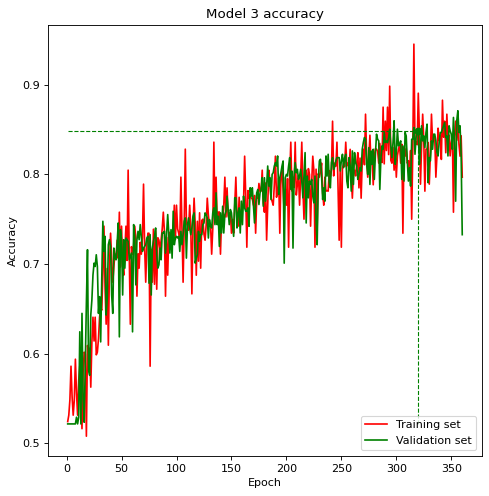

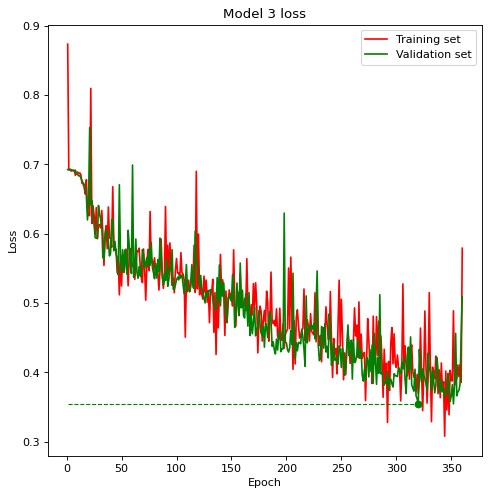

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_acc_3, 'r', label='Training set')
plt.plot(epochs_3, val_acc_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_acc_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_acc_3), opt_val_acc_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_3, tra_loss_3, 'r', label='Training set')
plt.plot(epochs_3, val_loss_3, 'g', label='Validation set')
plt.plot(opt_epoch_3, val_loss_3[opt_epoch_3-1], 'go')
plt.vlines(opt_epoch_3, min(val_loss_3), opt_val_loss_3, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_3, 1, opt_epoch_3, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 4

model_4 = models.Sequential()
model_4.add(layers.Input(shape=(150, 150, 1)))
model_4.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(48, activation='relu'))
model_4.add(layers.Dropout(0.5))
model_4.add(layers.Dense(1, activation='sigmoid'))

model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 48)             │     1,775,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868,385 (7.13 MB)

 Trainable params: 1,868,385 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_4_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_4.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_4 = model_4.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save final model
models.save_model(model_4, 'model_4_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5237 - loss: 0.6976
Epoch 1: val_loss improved from inf to 0.69225, saving model to model_4_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - accuracy: 0.5247 - loss: 0.6976 - val_accuracy: 0.5215 - val_loss: 0.6923
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4766 - loss: 0.6938

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.69225
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4766 - loss: 0.6938 - val_accuracy: 0.5215 - val_loss: 0.6923
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.5687 - loss: 0.6900
Epoch 3: val_loss improved from 0.69225 to 0.69185, saving model to model_4_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step - accuracy: 0.5678 - loss: 0.6901 - val_accuracy: 0.5215 - val_loss: 0.6919
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5156 - loss: 0.6947
Epoch 4: val_loss improved from 0.69185 to 0.69185, saving model to model_4_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.5156 - loss: 0.6947 - val_accuracy: 0.5215 - val_loss: 0.6919
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5418 - loss: 0.6904
Epoch 5: val_loss improved from 0.69185 to 0.69143, saving model to model_4_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.5422 - loss: 0.690

In [ ]:
# History of accuracy and loss
tra_loss_4 = history_4.history['loss']
tra_acc_4 = history_4.history['accuracy']
val_loss_4 = history_4.history['val_loss']
val_acc_4 = history_4.history['val_accuracy']

# Total number of epochs training
epochs_4 = range(1, len(tra_acc_4) + 1)
end_epoch_4 = len(tra_acc_4)

# Epoch when reached the validation loss minimum
opt_epoch_4 = val_loss_4.index(min(val_loss_4)) + 1

# Loss and accuracy on the validation set
end_val_loss_4 = val_loss_4[-1]
end_val_acc_4 = val_acc_4[-1]
opt_val_loss_4 = val_loss_4[opt_epoch_4 - 1]
opt_val_acc_4 = val_acc_4[opt_epoch_4 - 1]

# Load the best saved model (make sure filename matches your saved model)
opt_model_4 = models.load_model('model_4_MC_best.keras')

# Evaluate the model on test data
test_loss_4, test_acc_4 = model_4.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_4, opt_test_acc_4 = opt_model_4.evaluate(test_images, test_labels, verbose=False)

# Predict on test images only (no labels here)
opt_pred_4 = opt_model_4.predict(test_images)

# Round predictions to get predicted classes (for binary classification)
pred_classes_4 = np.rint(opt_pred_4)

print("Model 4\n")

print("Epoch [end]: %d" % end_epoch_4)
print("Epoch [opt]: %d" % opt_epoch_4)
print("Valid accuracy [end]: %.4f" % end_val_acc_4)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_4)
print("Test accuracy [end]:  %.4f" % test_acc_4)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_4)
print("Valid loss [end]: %.4f" % end_val_loss_4)
print("Valid loss [opt]: %.4f" % opt_val_loss_4)
print("Test loss [end]:  %.4f" % test_loss_4)
print("Test loss [opt]:  %.4f" % opt_test_loss_4)

print(classification_report(test_labels, pred_classes_4, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Model 4

Epoch [end]: 500
Epoch [opt]: 486
Valid accuracy [end]: 0.8692
Valid accuracy [opt]: 0.8804
Test accuracy [end]:  0.8423
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.3046
Valid loss [opt]: 0.3011
Test loss [end]:  0.3896
Test loss [opt]:  0.3644
              precision    recall  f1-score   support

           0     0.9018    0.8212    0.8596       179
           1     0.8150    0.8981    0.8545       157

    accuracy                         0.8571       336
   macro avg     0.8584    0.8597    0.8571       336
weighted avg     0.8613    0.8571    0.8573       336



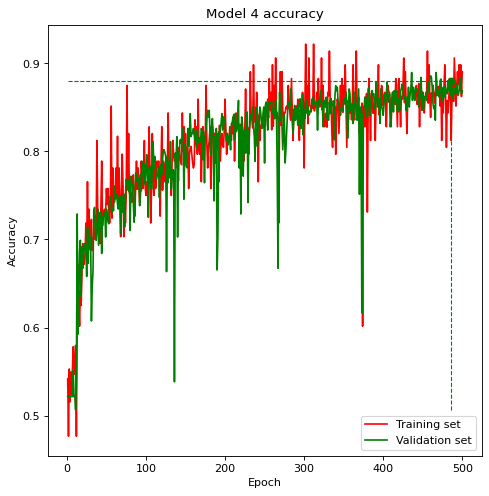

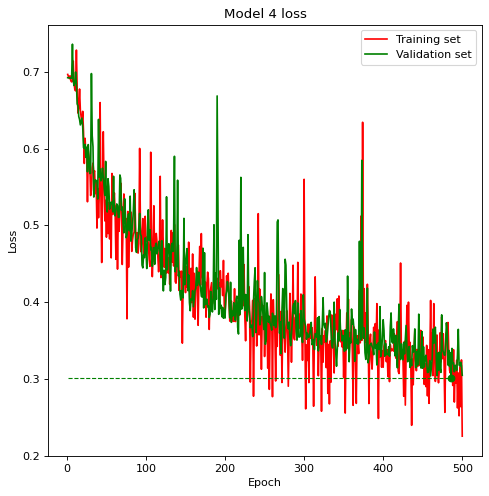

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 4 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_4, tra_acc_4, 'r', label='Training set')
plt.plot(epochs_4, val_acc_4, 'g', label='Validation set')
plt.plot(opt_epoch_4, val_acc_4[opt_epoch_4-1], 'go')
plt.vlines(opt_epoch_4, min(val_acc_4), opt_val_acc_4, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_4, 1, opt_epoch_4, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 4 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_4, tra_loss_4, 'r', label='Training set')
plt.plot(epochs_4, val_loss_4, 'g', label='Validation set')
plt.plot(opt_epoch_4, val_loss_4[opt_epoch_4-1], 'go')
plt.vlines(opt_epoch_4, min(val_loss_4), opt_val_loss_4, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_4, 1, opt_epoch_4, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 5

model_5 = models.Sequential()
model_5.add(layers.Input(shape=(150, 150, 1)))
model_5.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_5.add(layers.MaxPooling2D((2, 2)))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(48, activation='relu'))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(1, activation='sigmoid'))

model_5.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 48)             │     1,775,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868,385 (7.13 MB)

 Trainable params: 1,868,385 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_5_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)
# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)

# Compile the model (note the decay!)
model_5.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_5 = model_5.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, lr_scheduler],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)
# Save final model
models.save_model(model_5, 'model_5_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5256 - loss: 0.7761
Epoch 1: val_loss improved from inf to 0.69922, saving model to model_5_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.5286 - loss: 0.7705 - val_accuracy: 0.5159 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 2/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5597 - loss: 0.6898
Epoch 2: val_loss did not improve from 0.69922
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5611 - loss: 0.6895 - val_accuracy: 0.5159 - val_loss: 0.7027 - learning_rate: 9.9900e-04
Epoch 3/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5865 - loss: 0.6960
Epoch 3: val_loss improved from 0.69922 to 0.69419, saving model to model_5_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5836 - loss: 0.6960 - val_accuracy: 0.5159 - val_loss: 0.6942 - learning_rate: 9.9800e-04
Epoch 4/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5723 - loss: 0.6908
Epoch

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss did not improve from 0.69346
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6458 - loss: 0.6808 - val_accuracy: 0.5159 - val_loss: 0.6942 - learning_rate: 9.9602e-04
Epoch 6/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5933 - loss: 0.6858
Epoch 6: val_loss did not improve from 0.69346
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5934 - loss: 0.6866 - val_accuracy: 0.5159 - val_loss: 0.7051 - learning_rate: 9.9502e-04
Epoch 7/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5287 - loss: 0.6949
Epoch 7: val_loss did not improve from 0.69346
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5326 - loss: 0.6942 - val_accuracy: 0.5159 - val_loss: 0.6957 - learning_rate: 9.9404e-04
Epoch 8/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6381 - loss: 0.6697
Epoch 8: val_loss did not improve from 0.69346
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6336 - loss: 0.6710 - val_accuracy: 0.5159 - val_loss: 0.6958 - lea

In [ ]:
# History of accuracy and loss
tra_loss_5 = history_5.history['loss']
tra_acc_5 = history_5.history['accuracy']
val_loss_5 = history_5.history['val_loss']
val_acc_5 = history_5.history['val_accuracy']

# Total number of epochs training
epochs_5 = range(1, len(tra_acc_5) + 1)
end_epoch_5 = len(tra_acc_5)

# Epoch when reached the validation loss minimum
opt_epoch_5 = val_loss_5.index(min(val_loss_5)) + 1

# Loss and accuracy on the validation set
end_val_loss_5 = val_loss_5[-1]
end_val_acc_5 = val_acc_5[-1]
opt_val_loss_5 = val_loss_5[opt_epoch_5 - 1]
opt_val_acc_5 = val_acc_5[opt_epoch_5 - 1]

# Load the best saved model (ensure the filename is correct)
opt_model_5 = models.load_model('model_5_MC_best.keras')

# Evaluate the current and best model on test data
test_loss_5, test_acc_5 = model_5.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_5, opt_test_acc_5 = opt_model_5.evaluate(test_images, test_labels, verbose=False)

# Predict on test images only (do NOT pass labels to predict)
opt_pred_5 = opt_model_5.predict(test_images)

# Round predictions to get predicted classes (binary classification assumed)
pred_classes_5 = np.rint(opt_pred_5)

print("Model 5\n")

print(f"Epoch [end]: {end_epoch_5}")
print(f"Epoch [opt]: {opt_epoch_5}")
print(f"Valid accuracy [end]: {end_val_acc_5:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_5:.4f}")
print(f"Test accuracy [end]:  {test_acc_5:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_5:.4f}")
print(f"Valid loss [end]: {end_val_loss_5:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_5:.4f}")
print(f"Test loss [end]:  {test_loss_5:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_5:.4f}")

print(classification_report(test_labels, pred_classes_5, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Model 5

Epoch [end]: 291
Epoch [opt]: 211
Valid accuracy [end]: 0.8636
Valid accuracy [opt]: 0.8785
Test accuracy [end]:  0.8006
Test accuracy [opt]:  0.8185
Valid loss [end]: 0.3785
Valid loss [opt]: 0.3333
Test loss [end]:  0.6792
Test loss [opt]:  0.4725
              precision    recall  f1-score   support

           0     0.8391    0.8156    0.8272       179
           1     0.7963    0.8217    0.8088       157

    accuracy                         0.8185       336
   macro avg     0.8177    0.8186    0.8180       336
weighted avg     0.8191    0.8185    0.8186       336



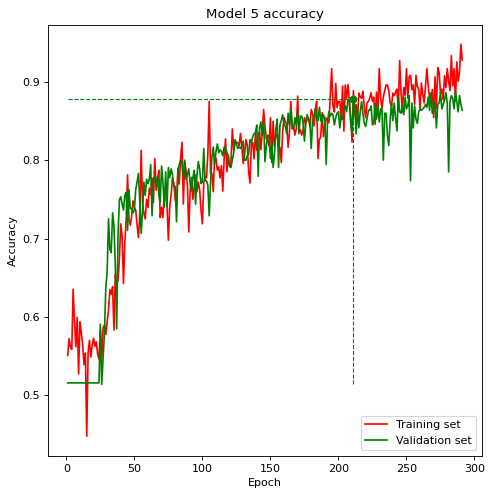

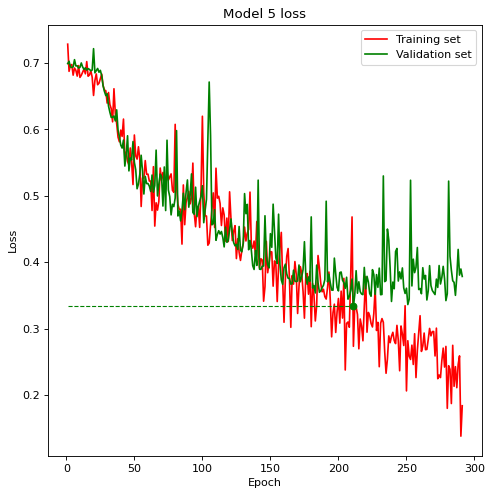

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 5 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_acc_5, 'r', label='Training set')
plt.plot(epochs_5, val_acc_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_acc_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_acc_5), opt_val_acc_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 5 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_5, tra_loss_5, 'r', label='Training set')
plt.plot(epochs_5, val_loss_5, 'g', label='Validation set')
plt.plot(opt_epoch_5, val_loss_5[opt_epoch_5-1], 'go')
plt.vlines(opt_epoch_5, min(val_loss_5), opt_val_loss_5, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_5, 1, opt_epoch_5, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 6

model_6 = models.Sequential()
model_6.add(layers.Input(shape=(150, 150, 1)))
model_6.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_6.add(layers.MaxPooling2D((2, 2)))
model_6.add(layers.Flatten())
model_6.add(layers.Dense(48, activation='relu'))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(1, activation='sigmoid'))

model_6.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 48)             │       602,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 990,049 (3.78 MB)

 Trainable params: 990,049 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_6_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)


# Compile the model (note the decay!)
model_6.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_6 = model_6.fit(
        train_generator,
        steps_per_epoch=num_of_train_img // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, lr_scheduler],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save final model
models.save_model(model_6, 'model_6_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5294 - loss: 0.6983
Epoch 1: val_loss improved from inf to 0.69117, saving model to model_6_MC_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.5318 - loss: 0.6978 - val_accuracy: 0.5159 - val_loss: 0.6912 - learning_rate: 0.0010
Epoch 2/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5138 - loss: 0.6930
Epoch 2: val_loss did not improve from 0.69117
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5157 - loss: 0.6931 - val_accuracy: 0.5159 - val_loss: 0.6928 - learning_rate: 9.9900e-04
Epoch 3/500
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5546 - loss: 0.6888
Epoch 3: val_loss improved from 0.69117 to 0.68858, saving model to model_6_MC_best.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5553 - loss: 0.6886 - val_accuracy: 0.5159 - val_loss: 0.6886 - learning_rate: 9.9800e-04
Epoch 4/500
 7/20 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5518 - loss: 0.6900
Epoch

In [ ]:
# History of accuracy and loss
tra_loss_6 = history_6.history['loss']
tra_acc_6 = history_6.history['accuracy']
val_loss_6 = history_6.history['val_loss']
val_acc_6 = history_6.history['val_accuracy']

# Total number of epochs training
epochs_6 = range(1, len(tra_acc_6) + 1)
end_epoch_6 = len(tra_acc_6)

# Epoch when validation loss was minimum
opt_epoch_6 = val_loss_6.index(min(val_loss_6)) + 1

# Loss and accuracy on the validation set
end_val_loss_6 = val_loss_6[-1]
end_val_acc_6 = val_acc_6[-1]
opt_val_loss_6 = val_loss_6[opt_epoch_6 - 1]
opt_val_acc_6 = val_acc_6[opt_epoch_6 - 1]

# Load the best saved model
opt_model_6 = models.load_model('model_6_MC_best.keras')

# Evaluate current and best model on test data
test_loss_6, test_acc_6 = model_6.evaluate(test_images, test_labels, verbose=0)
opt_test_loss_6, opt_test_acc_6 = opt_model_6.evaluate(test_images, test_labels, verbose=0)

# Predict test labels (do not pass test_labels into predict!)
opt_pred_6 = opt_model_6.predict(test_images)
pred_classes_6 = np.rint(opt_pred_6).astype(int)  # Round predictions to 0/1 and convert to int

# Print results
print("Model 6\n")
print(f"Epoch [end]: {end_epoch_6}")
print(f"Epoch [opt]: {opt_epoch_6}")
print(f"Valid accuracy [end]: {end_val_acc_6:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_6:.4f}")
print(f"Test accuracy [end]:  {test_acc_6:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_6:.4f}")
print(f"Valid loss [end]: {end_val_loss_6:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_6:.4f}")
print(f"Test loss [end]:  {test_loss_6:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_6:.4f}")

# Print classification report
print(classification_report(test_labels, pred_classes_6, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Model 6

Epoch [end]: 184
Epoch [opt]: 104
Valid accuracy [end]: 0.8449
Valid accuracy [opt]: 0.8449
Test accuracy [end]:  0.8036
Test accuracy [opt]:  0.8036
Valid loss [end]: 0.5540
Valid loss [opt]: 0.3354
Test loss [end]:  0.7005
Test loss [opt]:  0.4282
              precision    recall  f1-score   support

           0     0.7868    0.8659    0.8245       179
           1     0.8273    0.7325    0.7770       157

    accuracy                         0.8036       336
   macro avg     0.8071    0.7992    0.8007       336
weighted avg     0.8057    0.8036    0.8023       336



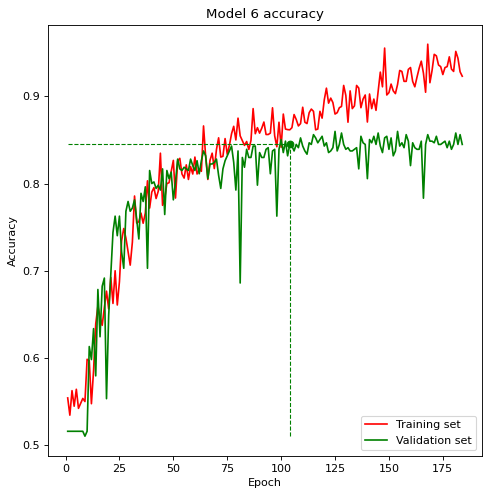

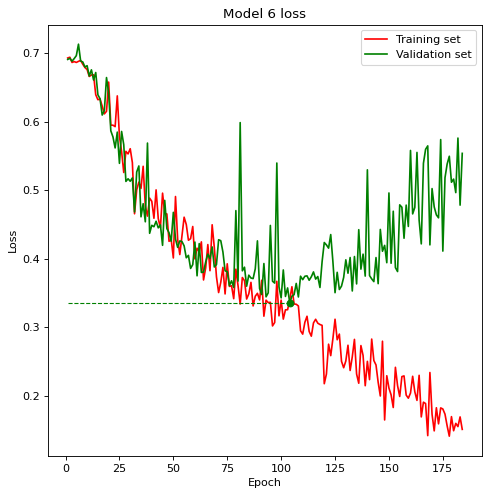

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_acc_6, 'r', label='Training set')
plt.plot(epochs_6, val_acc_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_acc_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_acc_6), opt_val_acc_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 6 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_6, tra_loss_6, 'r', label='Training set')
plt.plot(epochs_6, val_loss_6, 'g', label='Validation set')
plt.plot(opt_epoch_6, val_loss_6[opt_epoch_6-1], 'go')
plt.vlines(opt_epoch_6, min(val_loss_6), opt_val_loss_6, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_6, 1, opt_epoch_6, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 7

model_7 = models.Sequential()
model_7.add(layers.Input(shape=(150, 150, 1)))
model_7.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))
model_7.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))
model_7.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_7.add(layers.MaxPooling2D((2, 2)))
model_7.add(layers.Flatten())
model_7.add(layers.Dense(48, activation='relu'))
model_7.add(layers.Dropout(0.5))
model_7.add(layers.Dense(1, activation='sigmoid'))

model_7.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 73, 73, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 48)             │       301,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,337 (1.50 MB)

 Trainable params: 394,337 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_7_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 0.001  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)

# Compile the model (note the decay!)
model_7.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_7 = model_7.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping, lr_scheduler],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save final model
models.save_model(model_7, 'model_7_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"


Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5822 - loss: 0.7048
Epoch 1: val_loss improved from inf to 0.69490, saving model to model_7_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5815 - loss: 0.7046 - val_accuracy: 0.5159 - val_loss: 0.6949 - learning_rate: 0.0010
Epoch 2/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5386 - loss: 0.6914
Epoch 2: val_loss improved from 0.69490 to 0.69259, saving model to model_7_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5376 - loss: 0.6916 - val_accuracy: 0.5159 - val_loss: 0.6926 - learning_rate: 9.9900e-04
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5620 - loss: 0.6903
Epoch 3: val_loss improved from 0.69259 to 0.69234, saving model to model_7_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5621 - loss: 0.6904 - val_accuracy: 0.5159 - val_loss: 0.6923 - learning_rate: 9.9800e-04
Epoch 4/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/s

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5797 - loss: 0.6830
Epoch 6: val_loss did not improve from 0.69219
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5798 - loss: 0.6829 - val_accuracy: 0.5159 - val_loss: 0.7008 - learning_rate: 9.9502e-04
Epoch 7/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5234 - loss: 0.6941
Epoch 7: val_loss improved from 0.69219 to 0.69119, saving model to model_7_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5232 - loss: 0.6942 - val_accuracy: 0.5159 - val_loss: 0.6912 - learning_rate: 9.9404e-04
Epoch 8/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5208 - loss: 0.6916
Epoch 8: val_loss did not improve from 0.69119
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5215 - loss: 0.6915 - val_accuracy: 0.5159 - val_loss: 0.6917 - learning_rate: 9.9305e-04
Epoch 9/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5474 - loss: 0.6903
Epoch 9: val_loss did not improve from 0.69119
16/16

In [ ]:
tra_loss_7 = history_7.history['loss']
tra_acc_7 = history_7.history['accuracy']
val_loss_7 = history_7.history['val_loss']
val_acc_7 = history_7.history['val_accuracy']

# Total number of training epochs
epochs_7 = range(1, len(tra_acc_7) + 1)
end_epoch_7 = len(tra_acc_7)

# Epoch with minimum validation loss
opt_epoch_7 = val_loss_7.index(min(val_loss_7)) + 1

# Final and optimal validation performance
end_val_loss_7 = val_loss_7[-1]
end_val_acc_7 = val_acc_7[-1]
opt_val_loss_7 = val_loss_7[opt_epoch_7 - 1]
opt_val_acc_7 = val_acc_7[opt_epoch_7 - 1]

# Load best saved model
opt_model_7 = models.load_model('model_7_MC_best.keras')

# Evaluate both current model and best checkpoint
test_loss_7, test_acc_7 = model_7.evaluate(test_images, test_labels, verbose=0)
opt_test_loss_7, opt_test_acc_7 = opt_model_7.evaluate(test_images, test_labels, verbose=0)

# Predict classes from best model — only use test_images (not both images and labels!)
opt_pred_7 = opt_model_7.predict(test_images)
pred_classes_7 = np.rint(opt_pred_7).astype(int)

# Print model performance summary
print("Model 7\n")
print(f"Epoch [end]: {end_epoch_7}")
print(f"Epoch [opt]: {opt_epoch_7}")
print(f"Valid accuracy [end]: {end_val_acc_7:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_7:.4f}")
print(f"Test accuracy [end]:  {test_acc_7:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_7:.4f}")
print(f"Valid loss [end]: {end_val_loss_7:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_7:.4f}")
print(f"Test loss [end]:  {test_loss_7:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_7:.4f}")

# Classification metrics
print(classification_report(test_labels, pred_classes_7, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model 7

Epoch [end]: 237
Epoch [opt]: 157
Valid accuracy [end]: 0.8430
Valid accuracy [opt]: 0.8729
Test accuracy [end]:  0.8185
Test accuracy [opt]:  0.8274
Valid loss [end]: 0.4916
Valid loss [opt]: 0.3161
Test loss [end]:  0.6038
Test loss [opt]:  0.4171
              precision    recall  f1-score   support

           0     0.8270    0.8547    0.8407       179
           1     0.8278    0.7962    0.8117       157

    accuracy                         0.8274       336
   macro avg     0.8274    0.8255    0.8262       336
weighted avg     0.8274    0.8274    0.8271       336



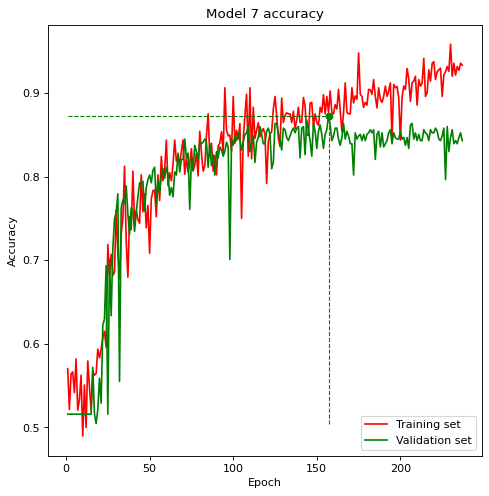

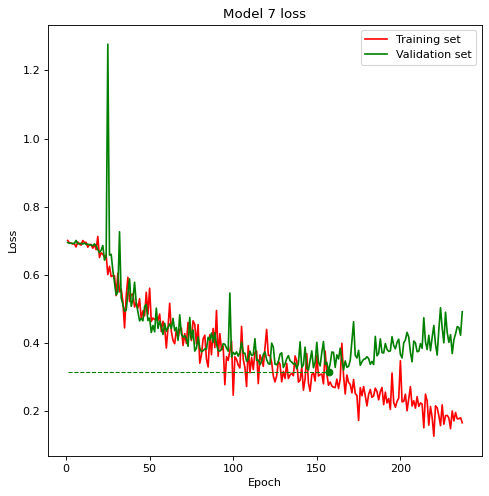

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 7 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_7, tra_acc_7, 'r', label='Training set')
plt.plot(epochs_7, val_acc_7, 'g', label='Validation set')
plt.plot(opt_epoch_7, val_acc_7[opt_epoch_7-1], 'go')
plt.vlines(opt_epoch_7, min(val_acc_7), opt_val_acc_7, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_7, 1, opt_epoch_7, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 7 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_7, tra_loss_7, 'r', label='Training set')
plt.plot(epochs_7, val_loss_7, 'g', label='Validation set')
plt.plot(opt_epoch_7, val_loss_7[opt_epoch_7-1], 'go')
plt.vlines(opt_epoch_7, min(val_loss_7), opt_val_loss_7, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_7, 1, opt_epoch_7, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 8

model_8 = models.Sequential()
model_8.add(layers.Input(shape=(150, 150, 1)))
model_8.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))
model_8.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))
model_8.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_8.add(layers.MaxPooling2D((2, 2)))
model_8.add(layers.Flatten())
model_8.add(layers.Dense(48, activation='relu'))
model_8.add(layers.Dropout(0.5))
model_8.add(layers.Dense(1, activation='sigmoid'))

model_8.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 48)             │     1,775,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,868,385 (7.13 MB)

 Trainable params: 1,868,385 (7.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=60, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_8_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Custom decay function to match RMSprop's decay behavior
def lr_decay(epoch, lr):
    initial_lr = 1e-4  # Your initial learning rate
    decay_rate = 1e-3  # Same decay as in RMSprop
    return initial_lr * (1 / (1 + decay_rate * epoch))

# Use the custom decay in the LearningRateScheduler
lr_scheduler = LearningRateScheduler(lr_decay)

# Compile the model (note the decay!)
model_8.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_8 = model_8.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)
# Save final model
models.save_model(model_8, 'model_8_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4730 - loss: 0.6954
Epoch 1: val_loss improved from inf to 0.69469, saving model to model_8_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.4783 - loss: 0.6952 - val_accuracy: 0.5159 - val_loss: 0.6947
Epoch 2/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5389 - loss: 0.6916
Epoch 2: val_loss improved from 0.69469 to 0.69327, saving model to model_8_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.5399 - loss: 0.6915 - val_accuracy: 0.5159 - val_loss: 0.6933
Epoch 3/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5643 - loss: 0.6850
Epoch 3: val_loss did not improve from 0.69327
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5643 - loss: 0.6852 - val_accuracy: 0.5159 - val_loss: 0.6965
Epoch 4/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5909 - loss: 0.6878
Epoch 4: val_loss improved from 0.69327 to 0.69246, saving model to model_8_MC_best.k

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 5: val_loss improved from 0.69246 to 0.69213, saving model to model_8_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4740 - loss: 0.6918 - val_accuracy: 0.5159 - val_loss: 0.6921
Epoch 6/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5393 - loss: 0.6903
Epoch 6: val_loss improved from 0.69213 to 0.69156, saving model to model_8_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.5379 - loss: 0.6905 - val_accuracy: 0.5159 - val_loss: 0.6916
Epoch 7/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5856 - loss: 0.6873
Epoch 7: val_loss did not improve from 0.69156
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5827 - loss: 0.6875 - val_accuracy: 0.5159 - val_loss: 0.6920
Epoch 8/500
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5175 - loss: 0.6950
Epoch 8: val_loss did not improve from 0.69156
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5217 - loss: 0.6944 - val_accuracy: 0.5159 - val_loss: 0.6917
Epo

In [ ]:
tra_loss_8 = history_8.history['loss']
tra_acc_8 = history_8.history['accuracy']
val_loss_8 = history_8.history['val_loss']
val_acc_8 = history_8.history['val_accuracy']

# Total number of training epochs
epochs_8 = range(1, len(tra_acc_8) + 1)
end_epoch_8 = len(tra_acc_8)

# Epoch with the minimum validation loss
opt_epoch_8 = val_loss_8.index(min(val_loss_8)) + 1

# Final and optimal validation performance
end_val_loss_8 = val_loss_8[-1]
end_val_acc_8 = val_acc_8[-1]
opt_val_loss_8 = val_loss_8[opt_epoch_8 - 1]
opt_val_acc_8 = val_acc_8[opt_epoch_8 - 1]

# Load best model
opt_model_8 = models.load_model('model_8_MC_best.keras')

# Evaluate both current model and best checkpoint
test_loss_8, test_acc_8 = model_8.evaluate(test_images, test_labels, verbose=0)
opt_test_loss_8, opt_test_acc_8 = opt_model_8.evaluate(test_images, test_labels, verbose=0)

# Predictions (corrected to use only test_images)
opt_pred_8 = opt_model_8.predict(test_images)
pred_classes_8 = np.rint(opt_pred_8).astype(int)

# Print evaluation summary
print("Model 8\n")
print(f"Epoch [end]: {end_epoch_8}")
print(f"Epoch [opt]: {opt_epoch_8}")
print(f"Valid accuracy [end]: {end_val_acc_8:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_8:.4f}")
print(f"Test accuracy [end]:  {test_acc_8:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_8:.4f}")
print(f"Valid loss [end]: {end_val_loss_8:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_8:.4f}")
print(f"Test loss [end]:  {test_loss_8:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_8:.4f}")

# Show classification metrics
print(classification_report(test_labels, pred_classes_8, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Model 8

Epoch [end]: 500
Epoch [opt]: 494
Valid accuracy [end]: 0.8542
Valid accuracy [opt]: 0.8579
Test accuracy [end]:  0.8185
Test accuracy [opt]:  0.8244
Valid loss [end]: 0.3649
Valid loss [opt]: 0.3455
Test loss [end]:  0.4520
Test loss [opt]:  0.4567
              precision    recall  f1-score   support

           0     0.8061    0.8827    0.8427       179
           1     0.8500    0.7580    0.8013       157

    accuracy                         0.8244       336
   macro avg     0.8281    0.8203    0.8220       336
weighted avg     0.8266    0.8244    0.8234       336



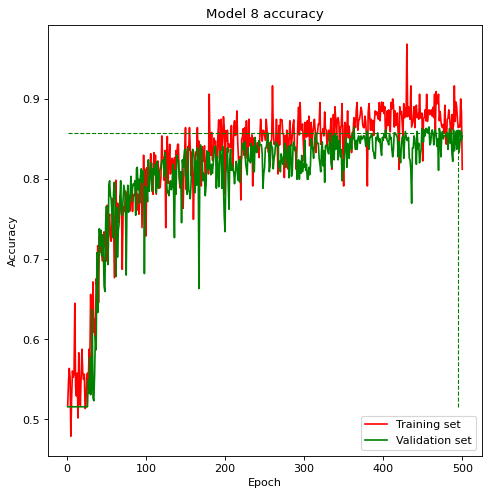

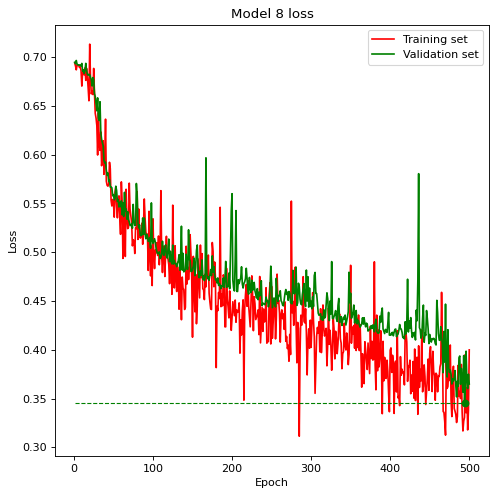

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 8 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_8, tra_acc_8, 'r', label='Training set')
plt.plot(epochs_8, val_acc_8, 'g', label='Validation set')
plt.plot(opt_epoch_8, val_acc_8[opt_epoch_8-1], 'go')
plt.vlines(opt_epoch_8, min(val_acc_8), opt_val_acc_8, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_8, 1, opt_epoch_8, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 8 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_8, tra_loss_8, 'r', label='Training set')
plt.plot(epochs_8, val_loss_8, 'g', label='Validation set')
plt.plot(opt_epoch_8, val_loss_8[opt_epoch_8-1], 'go')
plt.vlines(opt_epoch_8, min(val_loss_8), opt_val_loss_8, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_8, 1, opt_epoch_8, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 9

model_9 = models.Sequential()
model_9.add(layers.Input(shape=(150, 150, 1)))
model_9.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.00005)))
model_9.add(layers.MaxPooling2D((2, 2)))
model_9.add(layers.Flatten())
model_9.add(layers.Dense(48, activation='relu'))
model_9.add(layers.Dropout(0.5))
model_9.add(layers.Dense(1, activation='sigmoid'))

model_9.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 48)             │       602,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 990,049 (3.78 MB)

 Trainable params: 990,049 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=80, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_9_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model
model_9.compile(optimizer=RMSprop(learning_rate=0.001, weight_decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_9 = model_9.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=500,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)
# Save final model
models.save_model(model_9, 'model_9_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5334 - loss: 0.7108
Epoch 1: val_loss improved from inf to 0.70688, saving model to model_9_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 492ms/step - accuracy: 0.5336 - loss: 0.7107 - val_accuracy: 0.5215 - val_loss: 0.7069
Epoch 2/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5859 - loss: 0.7033

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss did not improve from 0.70688
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5859 - loss: 0.7033 - val_accuracy: 0.5215 - val_loss: 0.7078
Epoch 3/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5564 - loss: 0.7032
Epoch 3: val_loss improved from 0.70688 to 0.70672, saving model to model_9_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 275ms/step - accuracy: 0.5562 - loss: 0.7032 - val_accuracy: 0.5215 - val_loss: 0.7067
Epoch 4/500
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5156 - loss: 0.7110
Epoch 4: val_loss improved from 0.70672 to 0.70587, saving model to model_9_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5156 - loss: 0.7110 - val_accuracy: 0.5215 - val_loss: 0.7059
Epoch 5/500
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.5613 - loss: 0.7027
Epoch 5: val_loss improved from 0.70587 to 0.70517, saving model to model_9_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.5606 - loss: 0.702

In [ ]:
tra_loss_9 = history_9.history['loss']
tra_acc_9 = history_9.history['accuracy']
val_loss_9 = history_9.history['val_loss']
val_acc_9 = history_9.history['val_accuracy']

# Total number of training epochs
epochs_9 = range(1, len(tra_acc_9) + 1)
end_epoch_9 = len(tra_acc_9)

# Epoch when validation loss is minimum
opt_epoch_9 = val_loss_9.index(min(val_loss_9)) + 1

# Final and best validation performance
end_val_loss_9 = val_loss_9[-1]
end_val_acc_9 = val_acc_9[-1]
opt_val_loss_9 = val_loss_9[opt_epoch_9 - 1]
opt_val_acc_9 = val_acc_9[opt_epoch_9 - 1]

# Load the best model
opt_model_9 = models.load_model('model_9_MC_best.keras')

# Evaluate current and best model
test_loss_9, test_acc_9 = model_9.evaluate(test_images, test_labels, verbose=0)
opt_test_loss_9, opt_test_acc_9 = opt_model_9.evaluate(test_images, test_labels, verbose=0)

# Predictions (only input test_images to predict)
opt_pred_9 = opt_model_9.predict(test_images)
pred_classes_9 = np.rint(opt_pred_9).astype(int)

# Print performance summary
print("Model 9\n")
print(f"Epoch [end]: {end_epoch_9}")
print(f"Epoch [opt]: {opt_epoch_9}")
print(f"Valid accuracy [end]: {end_val_acc_9:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_9:.4f}")
print(f"Test accuracy [end]:  {test_acc_9:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_9:.4f}")
print(f"Valid loss [end]: {end_val_loss_9:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_9:.4f}")
print(f"Test loss [end]:  {test_loss_9:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_9:.4f}")

# Classification metrics
print(classification_report(test_labels, pred_classes_9, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Model 9

Epoch [end]: 500
Epoch [opt]: 444
Valid accuracy [end]: 0.8953
Valid accuracy [opt]: 0.9084
Test accuracy [end]:  0.8601
Test accuracy [opt]:  0.8720
Valid loss [end]: 0.2516
Valid loss [opt]: 0.2477
Test loss [end]:  0.3766
Test loss [opt]:  0.4215
              precision    recall  f1-score   support

           0     0.9048    0.8492    0.8761       179
           1     0.8393    0.8981    0.8677       157

    accuracy                         0.8720       336
   macro avg     0.8720    0.8736    0.8719       336
weighted avg     0.8742    0.8720    0.8722       336



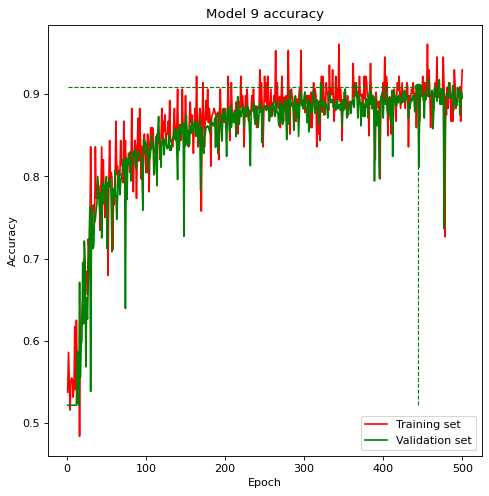

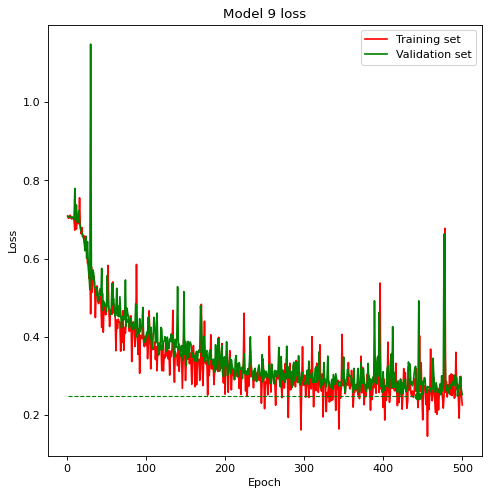

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 9 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_9, tra_acc_9, 'r', label='Training set')
plt.plot(epochs_9, val_acc_9, 'g', label='Validation set')
plt.plot(opt_epoch_9, val_acc_9[opt_epoch_9-1], 'go')
plt.vlines(opt_epoch_9, min(val_acc_9), opt_val_acc_9, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_9, 1, opt_epoch_9, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 9 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_9, tra_loss_9, 'r', label='Training set')
plt.plot(epochs_9, val_loss_9, 'g', label='Validation set')
plt.plot(opt_epoch_9, val_loss_9[opt_epoch_9-1], 'go')
plt.vlines(opt_epoch_9, min(val_loss_9), opt_val_loss_9, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_9, 1, opt_epoch_9, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
# Model 10

model_10 = models.Sequential()
model_10.add(layers.Input(shape=(150, 150, 1)))
model_10.add(layers.Conv2D(32, (3, 3)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Conv2D(64, (3, 3)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Conv2D(128, (3, 3)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Conv2D(256, (3, 3)))
model_10.add(layers.BatchNormalization())
model_10.add(layers.Activation("relu"))
model_10.add(layers.MaxPooling2D((2, 2)))
model_10.add(layers.Flatten())
model_10.add(layers.Dense(48, activation='relu'))
model_10.add(layers.Dropout(0.5))
model_10.add(layers.Dense(1, activation='sigmoid'))

model_10.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 48)             │       602,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,969 (3.78 MB)

 Trainable params: 991,009 (3.78 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_10_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_10.compile(optimizer=RMSprop(learning_rate=0.001, weight_decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_10 = model_10.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)
# Save final model
models.save_model(model_10, 'model_10_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.5190 - loss: 3.3894
Epoch 1: val_loss improved from inf to 0.69445, saving model to model_10_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 591ms/step - accuracy: 0.5191 - loss: 3.3125 - val_accuracy: 0.4785 - val_loss: 0.6945
Epoch 2/300
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5391 - loss: 0.7012

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.69445 to 0.69196, saving model to model_10_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5391 - loss: 0.7012 - val_accuracy: 0.5794 - val_loss: 0.6920
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.5868 - loss: 0.6669
Epoch 3: val_loss improved from 0.69196 to 0.68942, saving model to model_10_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.5879 - loss: 0.6664 - val_accuracy: 0.5626 - val_loss: 0.6894
Epoch 4/300
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5938 - loss: 0.8290
Epoch 4: val_loss did not improve from 0.68942
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5938 - loss: 0.8290 - val_accuracy: 0.4785 - val_loss: 0.6962
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6333 - loss: 0.6206
Epoch 5: val_loss did not improve from 0.68942
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.6339 - loss: 0.6190 - val_accuracy: 0.4785 - val_loss: 0.75

In [ ]:
tra_loss_10 = history_10.history['loss']
tra_acc_10 = history_10.history['accuracy']
val_loss_10 = history_10.history['val_loss']
val_acc_10 = history_10.history['val_accuracy']

# Total number of epochs training
epochs_10 = range(1, len(tra_acc_10) + 1)
end_epoch_10 = len(tra_acc_10)

# Epoch when validation loss is minimum
opt_epoch_10 = val_loss_10.index(min(val_loss_10)) + 1

# Loss and accuracy on the validation set
end_val_loss_10 = val_loss_10[-1]
end_val_acc_10 = val_acc_10[-1]
opt_val_loss_10 = val_loss_10[opt_epoch_10 - 1]
opt_val_acc_10 = val_acc_10[opt_epoch_10 - 1]

# Load the best model
opt_model_10 = models.load_model('model_10_MC_best.keras')

# Evaluate current and best model
test_loss_10, test_acc_10 = model_10.evaluate(test_images, test_labels, verbose=0)
opt_test_loss_10, opt_test_acc_10 = opt_model_10.evaluate(test_images, test_labels, verbose=0)

# Predictions (only input test_images to predict)
opt_pred_10 = opt_model_10.predict(test_images)
pred_classes_10 = np.rint(opt_pred_10).astype(int)

# Print performance summary
print("Model 10\n")
print(f"Epoch [end]: {end_epoch_10}")
print(f"Epoch [opt]: {opt_epoch_10}")
print(f"Valid accuracy [end]: {end_val_acc_10:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_10:.4f}")
print(f"Test accuracy [end]:  {test_acc_10:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_10:.4f}")
print(f"Valid loss [end]: {end_val_loss_10:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_10:.4f}")
print(f"Test loss [end]:  {test_loss_10:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_10:.4f}")

# Classification metrics
print(classification_report(test_labels, pred_classes_10, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
Model 10

Epoch [end]: 143
Epoch [opt]: 93
Valid accuracy [end]: 0.8822
Valid accuracy [opt]: 0.8766
Test accuracy [end]:  0.8661
Test accuracy [opt]:  0.8810
Valid loss [end]: 0.2985
Valid loss [opt]: 0.2925
Test loss [end]:  0.3511
Test loss [opt]:  0.3141
              precision    recall  f1-score   support

           0     0.8798    0.8994    0.8895       179
           1     0.8824    0.8599    0.8710       157

    accuracy                         0.8810       336
   macro avg     0.8811    0.8797    0.8802       336
weighted avg     0.8810    0.8810    0.8808       336



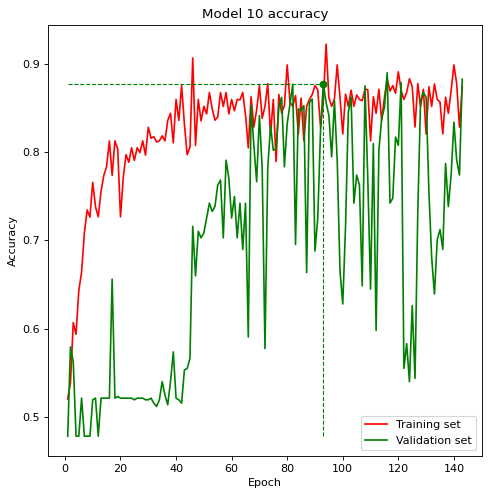

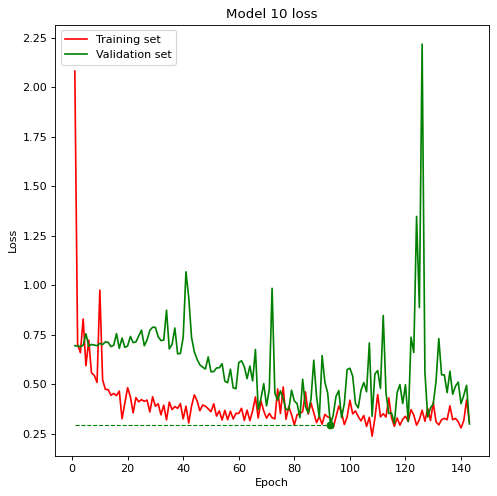

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 10 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_10, tra_acc_10, 'r', label='Training set')
plt.plot(epochs_10, val_acc_10, 'g', label='Validation set')
plt.plot(opt_epoch_10, val_acc_10[opt_epoch_10-1], 'go')
plt.vlines(opt_epoch_10, min(val_acc_10), opt_val_acc_10, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_10, 1, opt_epoch_10, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 10 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_10, tra_loss_10, 'r', label='Training set')
plt.plot(epochs_10, val_loss_10, 'g', label='Validation set')
plt.plot(opt_epoch_10, val_loss_10[opt_epoch_10-1], 'go')
plt.vlines(opt_epoch_10, min(val_loss_10), opt_val_loss_10, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_10, 1, opt_epoch_10, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:

# Model 11

model_11 = models.Sequential()
model_11.add(layers.Input(shape=(150, 150, 1)))
model_11.add(layers.Conv2D(32, (3, 3)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Conv2D(64, (3, 3)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Conv2D(128, (3, 3)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Conv2D(256, (3, 3)))
model_11.add(layers.BatchNormalization(momentum=0.001))
model_11.add(layers.Activation("relu"))
model_11.add(layers.MaxPooling2D((2, 2)))
model_11.add(layers.Flatten())
model_11.add(layers.Dense(48, activation='relu'))
model_11.add(layers.Dropout(0.5))
model_11.add(layers.Dense(1, activation='sigmoid'))

model_11.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 148, 148, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 15, 15, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 48)             │       602,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,969 (3.78 MB)

 Trainable params: 991,009 (3.78 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('model_11_MC_best.keras',
        monitor='val_loss', mode='min', verbose=1,
        save_best_only=True, save_freq='epoch'
)

# Compile the model (note the decay!)
model_11.compile(optimizer=RMSprop(learning_rate=0.001, weight_decay=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_11 = model_11.fit(
        train_generator,
        steps_per_epoch=int(0.8*num_of_train_img) // 128,
        epochs=300,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

# Save final model
models.save_model(model_11, 'model_11_MC_end.keras')

# Copy to Google Drive (if running in Colab)
!cp model* "/content/drive/My Drive/FYP_Project/models/"

Epoch 1/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5338 - loss: 3.5841
Epoch 1: val_loss improved from inf to 0.68027, saving model to model_11_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 588ms/step - accuracy: 0.5345 - loss: 3.4922 - val_accuracy: 0.5963 - val_loss: 0.6803
Epoch 2/300
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4844 - loss: 0.6847

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 0.68027 to 0.66820, saving model to model_11_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4844 - loss: 0.6847 - val_accuracy: 0.5234 - val_loss: 0.6682
Epoch 3/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.5616 - loss: 0.6688
Epoch 3: val_loss did not improve from 0.66820
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step - accuracy: 0.5616 - loss: 0.6694 - val_accuracy: 0.6131 - val_loss: 0.6718
Epoch 4/300
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5547 - loss: 0.6664
Epoch 4: val_loss did not improve from 0.66820
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5547 - loss: 0.6664 - val_accuracy: 0.5925 - val_loss: 0.6705
Epoch 5/300
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5276 - loss: 0.6760
Epoch 5: val_loss improved from 0.66820 to 0.65642, saving model to model_11_MC_best.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 276ms/step - accuracy: 0.5270 - loss: 0.6761 - val_accuracy: 0.6860 - val_loss: 0.65

In [ ]:
tra_loss_11 = history_11.history['loss']
tra_acc_11 = history_11.history['accuracy']  # Changed 'acc' to 'accuracy'
val_loss_11 = history_11.history['val_loss']
val_acc_11 = history_11.history['val_accuracy']  # Changed 'val_acc' to 'val_accuracy'

# Total number of epochs training
epochs_11 = range(1, len(tra_acc_11) + 1)
end_epoch_11 = len(tra_acc_11)

# Epoch when validation loss is minimum
opt_epoch_11 = val_loss_11.index(min(val_loss_11)) + 1

# Loss and accuracy on the validation set
end_val_loss_11 = val_loss_11[-1]
end_val_acc_11 = val_acc_11[-1]
opt_val_loss_11 = val_loss_11[opt_epoch_11 - 1]
opt_val_acc_11 = val_acc_11[opt_epoch_11 - 1]

# Load the best model
opt_model_11 = models.load_model('model_11_MC_best.keras')

# Evaluate current and best model
test_loss_11, test_acc_11 = model_11.evaluate(test_images, test_labels, verbose=0)
opt_test_loss_11, opt_test_acc_11 = opt_model_11.evaluate(test_images, test_labels, verbose=0)

# Predictions (only input test_images to predict)
opt_pred_11 = opt_model_11.predict(test_images)
pred_classes_11 = np.rint(opt_pred_11).astype(int)  # Rounding and converting to integer

# Print performance summary
print("Model 11\n")
print(f"Epoch [end]: {end_epoch_11}")
print(f"Epoch [opt]: {opt_epoch_11}")
print(f"Valid accuracy [end]: {end_val_acc_11:.4f}")
print(f"Valid accuracy [opt]: {opt_val_acc_11:.4f}")
print(f"Test accuracy [end]:  {test_acc_11:.4f}")
print(f"Test accuracy [opt]:  {opt_test_acc_11:.4f}")
print(f"Valid loss [end]: {end_val_loss_11:.4f}")
print(f"Valid loss [opt]: {opt_val_loss_11:.4f}")
print(f"Test loss [end]:  {test_loss_11:.4f}")
print(f"Test loss [opt]:  {opt_test_loss_11:.4f}")

# Classification metrics
print(classification_report(test_labels, pred_classes_11, digits=4))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
Model 11

Epoch [end]: 153
Epoch [opt]: 103
Valid accuracy [end]: 0.7159
Valid accuracy [opt]: 0.8841
Test accuracy [end]:  0.7202
Test accuracy [opt]:  0.8571
Valid loss [end]: 0.5361
Valid loss [opt]: 0.2976
Test loss [end]:  0.5697
Test loss [opt]:  0.3100
              precision    recall  f1-score   support

           0     0.8659    0.8659    0.8659       179
           1     0.8471    0.8471    0.8471       157

    accuracy                         0.8571       336
   macro avg     0.8565    0.8565    0.8565       336
weighted avg     0.8571    0.8571    0.8571       336



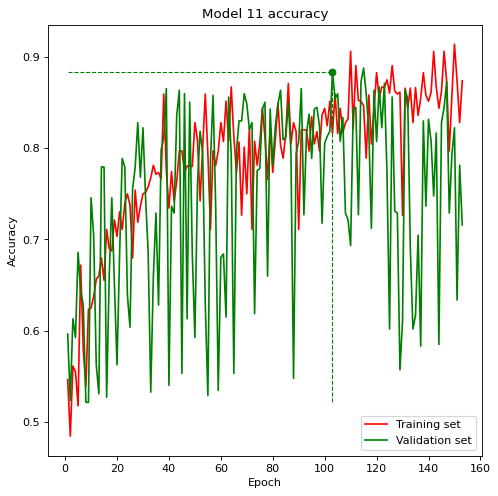

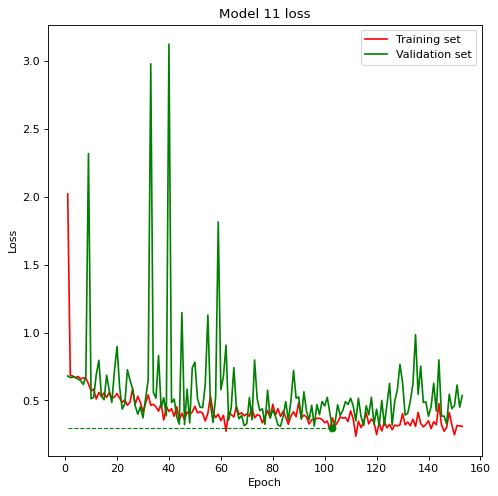

In [ ]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 11 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_11, tra_acc_11, 'r', label='Training set')
plt.plot(epochs_11, val_acc_11, 'g', label='Validation set')
plt.plot(opt_epoch_11, val_acc_11[opt_epoch_11-1], 'go')
plt.vlines(opt_epoch_11, min(val_acc_11), opt_val_acc_11, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_11, 1, opt_epoch_11, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('Model 11 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_11, tra_loss_11, 'r', label='Training set')
plt.plot(epochs_11, val_loss_11, 'g', label='Validation set')
plt.plot(opt_epoch_11, val_loss_11[opt_epoch_11-1], 'go')
plt.vlines(opt_epoch_11, min(val_loss_11), opt_val_loss_11, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_11, 1, opt_epoch_11, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [ ]:
!cp "/content/drive/My Drive/FYP_Project/models/model_5_MC_best.keras" .
!cp "/content/drive/My Drive/FYP_Project/models/model_6_MC_best.keras" .
!cp "/content/drive/My Drive/FYP_Project/models/model_9_MC_best.keras" .

In [ ]:
def get_errors(pred):
    errors = []
    mispred = []
    hard_mispred = []

    for l,p,img in zip(test_labels, pred, test_images):
        err = abs(l - p)
        errors.append(err)
        if err > 0.5:
            mispred.append((l,p,img))
        if err > 0.8:
            hard_mispred.append((l,p,img))

    return errors, mispred, hard_mispred


def show_error_stats(errors, mispred, hard_mispred):

    print("Number of test images: %d" % len(test_labels))
    print("Mispredictions: %d" % len(mispred))
    print("Hard mispred: %d" % len(hard_mispred))

    plt.hist(errors, bins=10, edgecolor='black', alpha=0.7)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Absolute Error Histogram')
    plt.grid(True)
    plt.show()


    for l,p,img in hard_mispred:
        plt.figure()
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))
        plt.axis('off')


opt_model_5 = models.load_model('model_5_MC_best.keras')
opt_model_6 = models.load_model('model_6_MC_best.keras')
opt_model_9 = models.load_model('model_9_MC_best.keras')

pred_5 = opt_model_5.predict(test_images)
pred_6 = opt_model_6.predict(test_images)
pred_9 = opt_model_9.predict(test_images)

errors_5, mispred_5, hard_mispred_5 = get_errors(pred_5)
errors_6, mispred_6, hard_mispred_6 = get_errors(pred_6)
errors_9, mispred_9, hard_mispred_9 = get_errors(pred_9)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Number of test images: 336
Mispredictions: 49
Hard mispred: 13


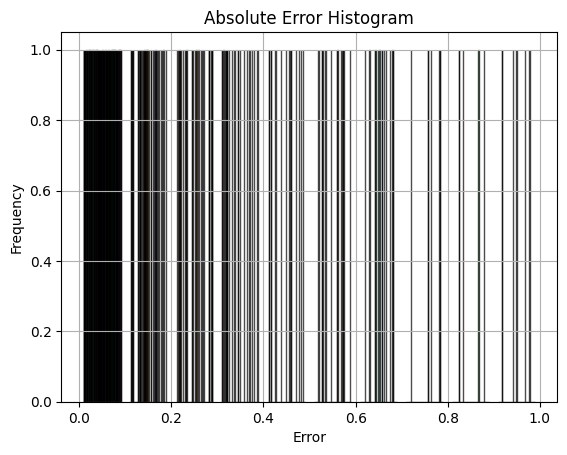

<ipython-input-78-1473394857>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))


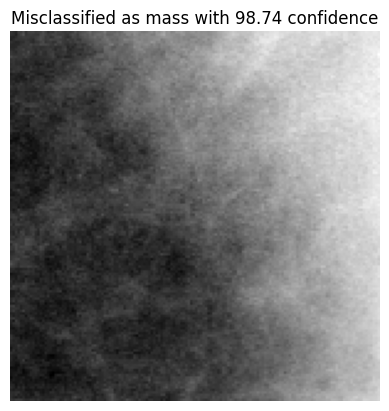

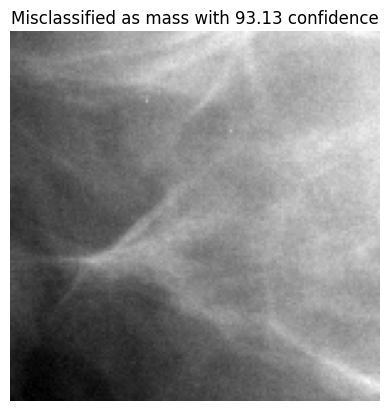

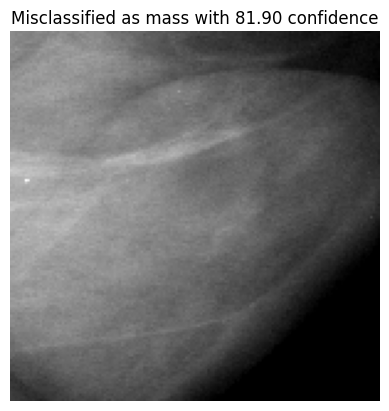

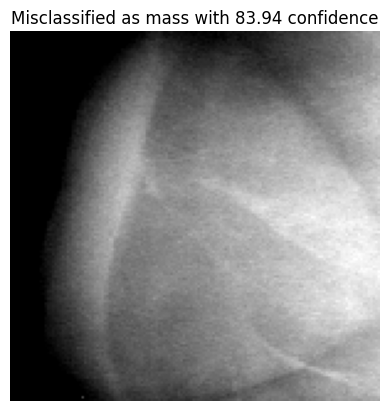

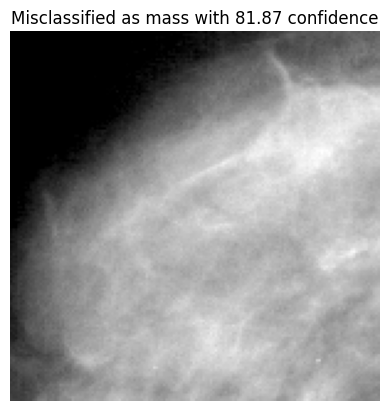

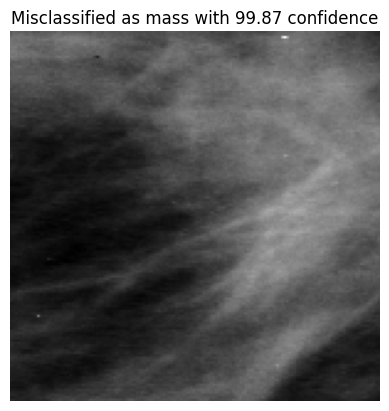

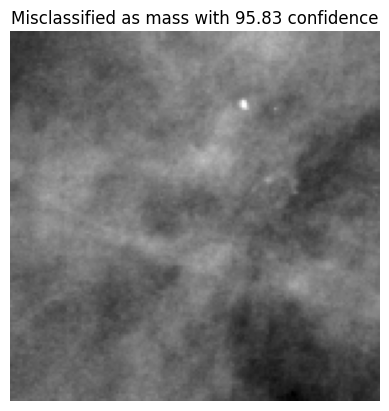

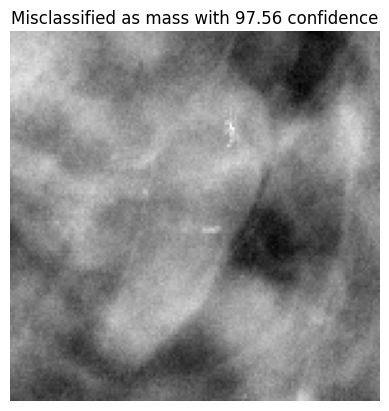

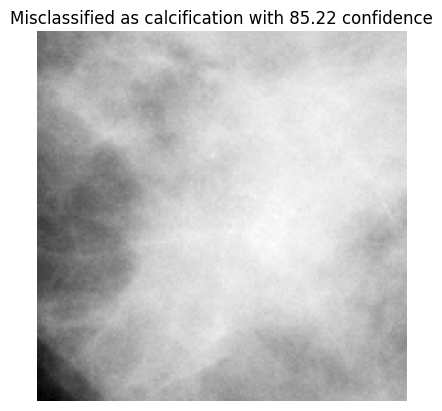

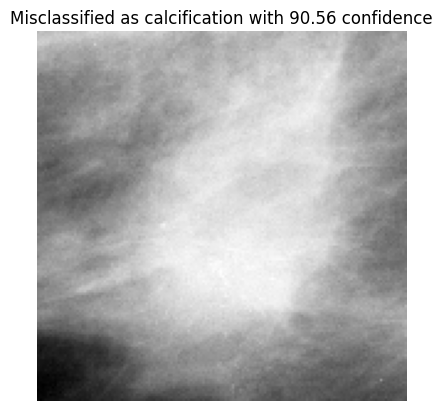

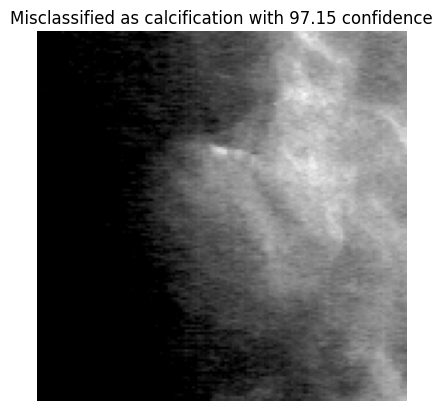

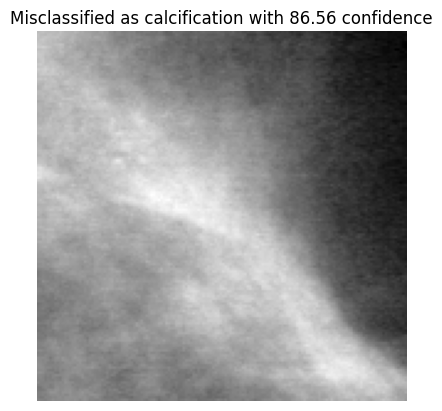

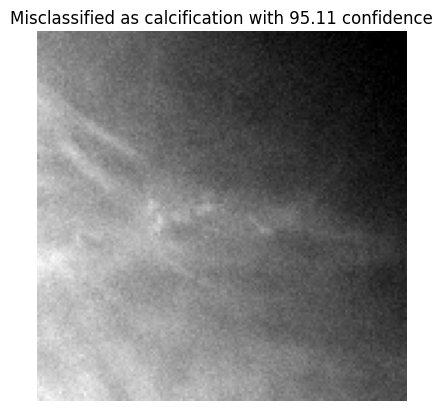

In [ ]:
show_error_stats(errors_5, mispred_5, hard_mispred_5)

Number of test images: 336
Mispredictions: 46
Hard mispred: 18


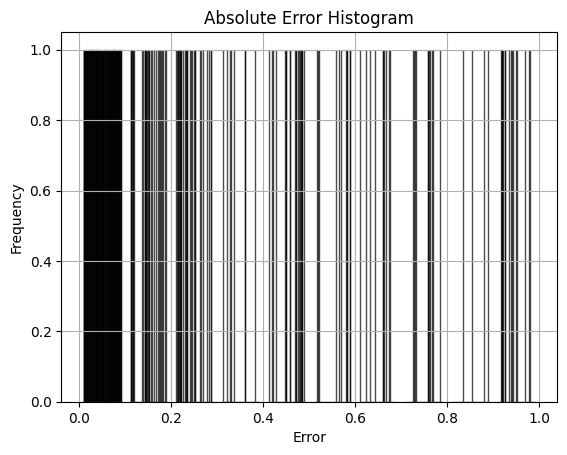

<ipython-input-78-1473394857>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))


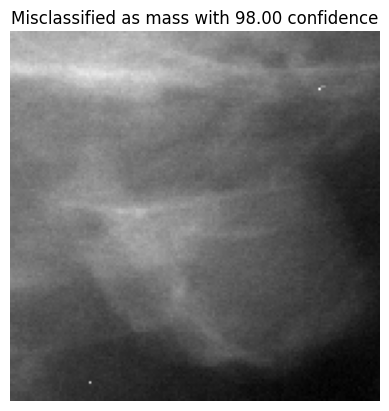

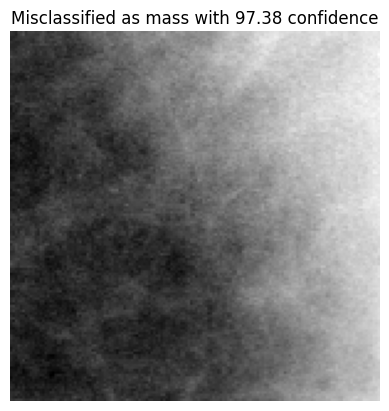

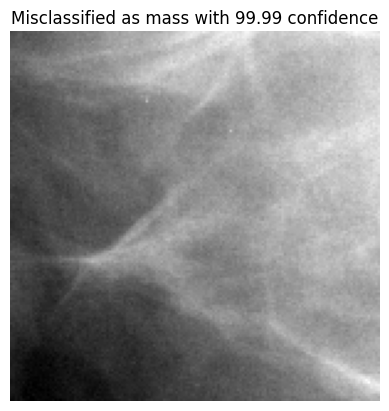

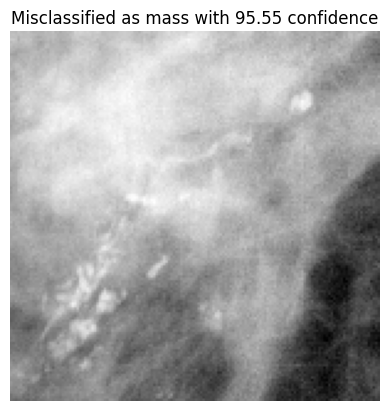

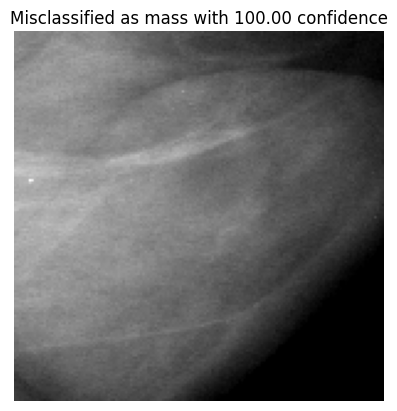

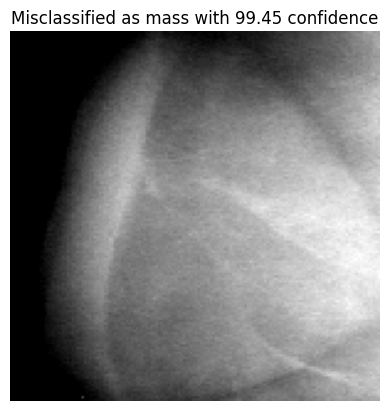

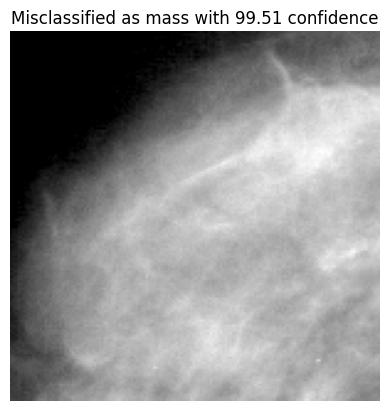

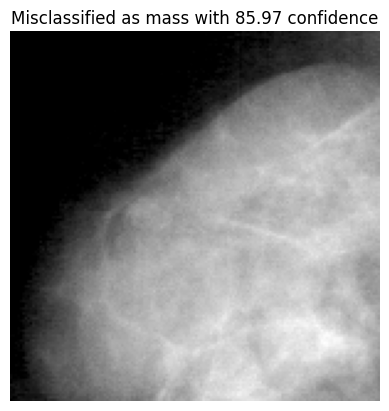

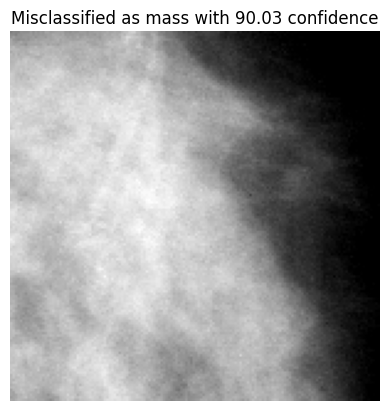

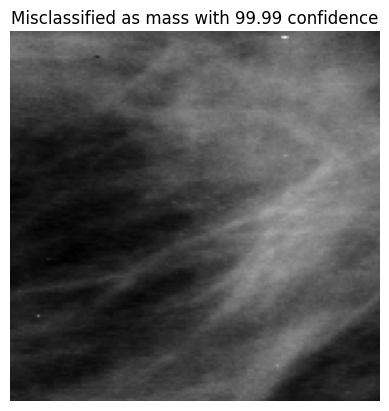

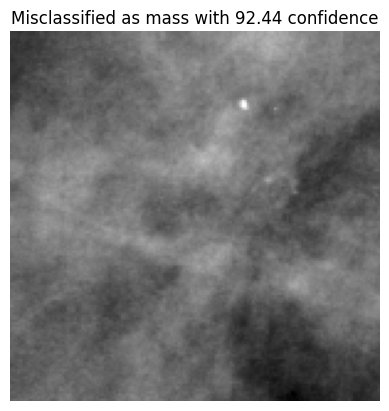

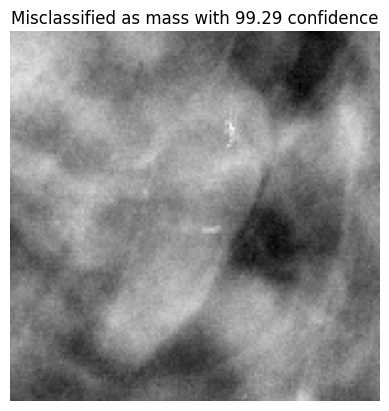

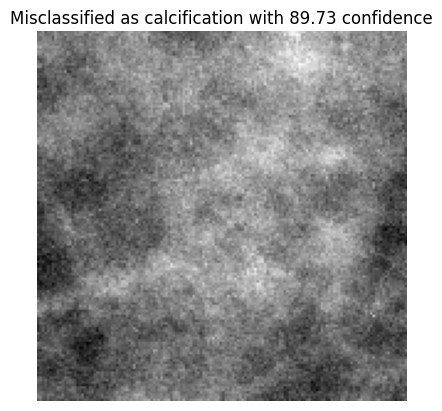

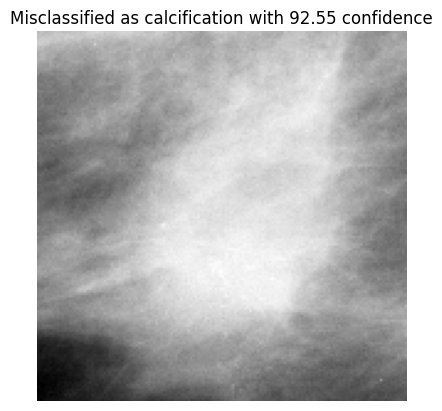

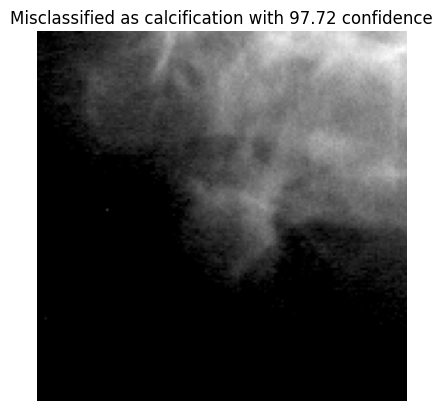

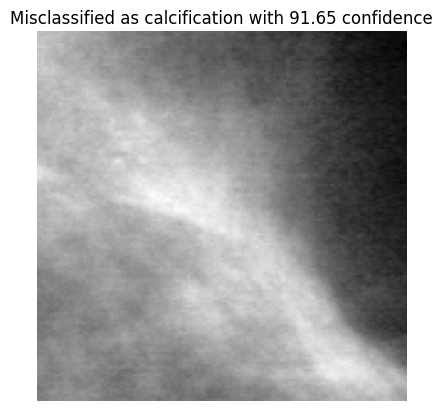

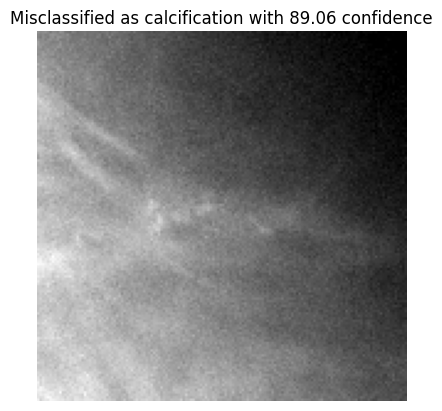

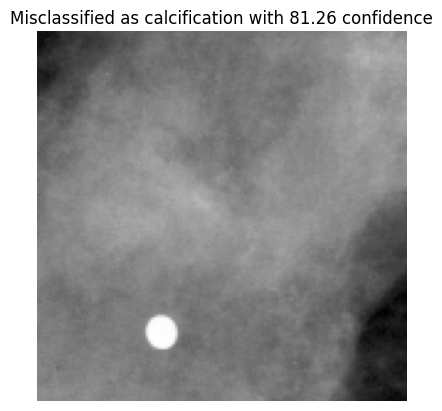

In [ ]:
show_error_stats(errors_6, mispred_6, hard_mispred_6)

Number of test images: 336
Mispredictions: 47
Hard mispred: 16


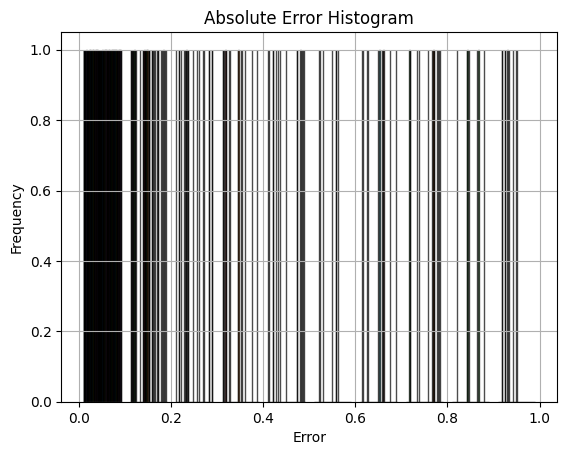

<ipython-input-78-1473394857>:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('Misclassified as ' + ('mass' if l==0 else 'calcification') + ' with %.2f confidence' % (100*abs(p-l)))


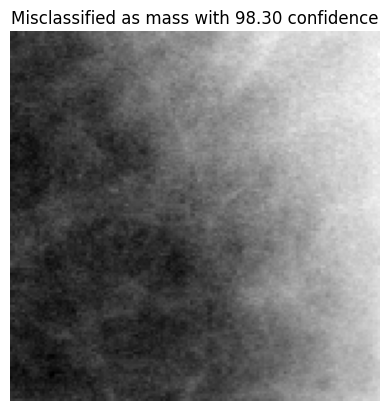

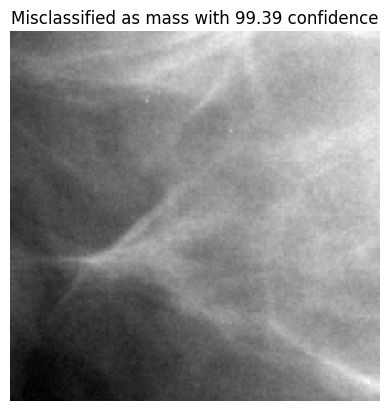

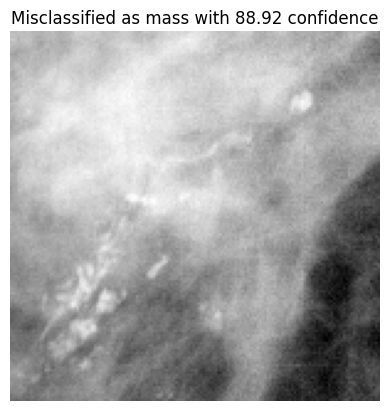

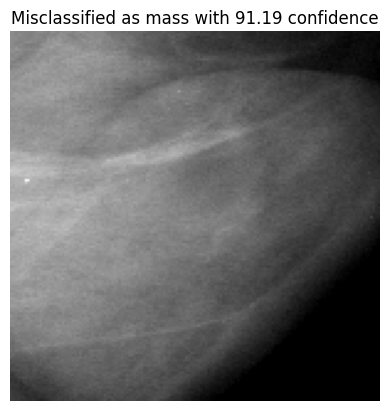

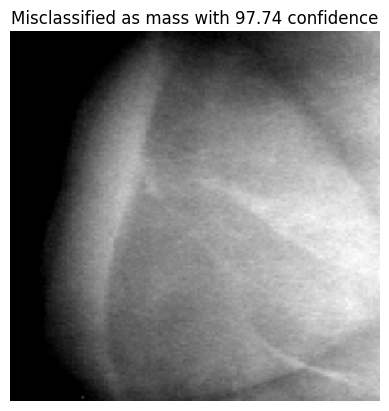

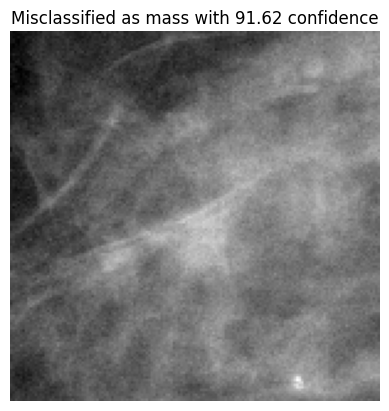

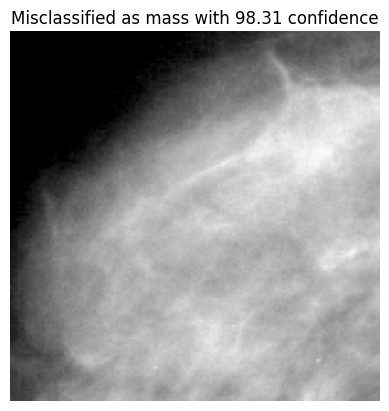

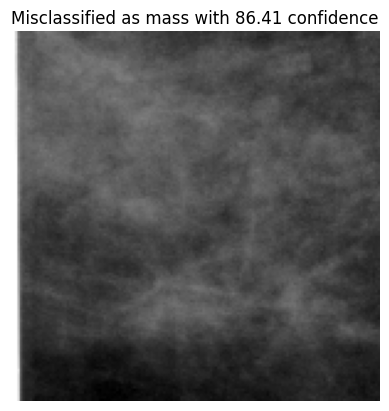

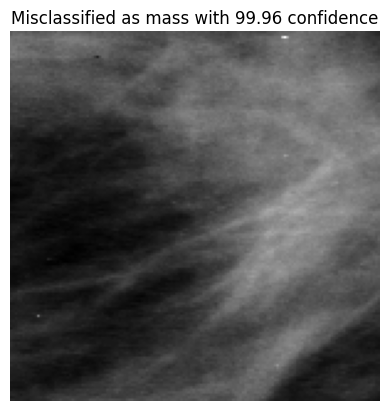

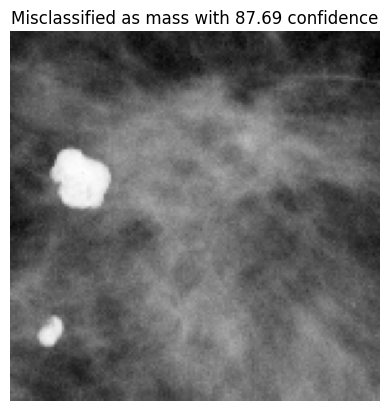

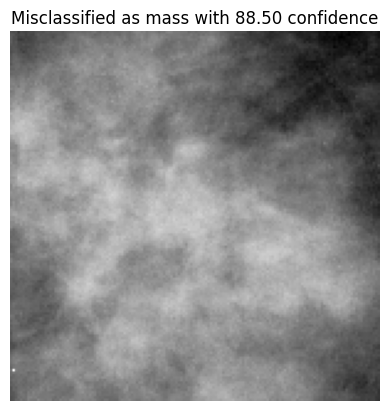

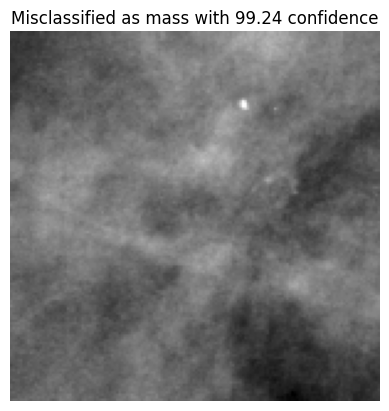

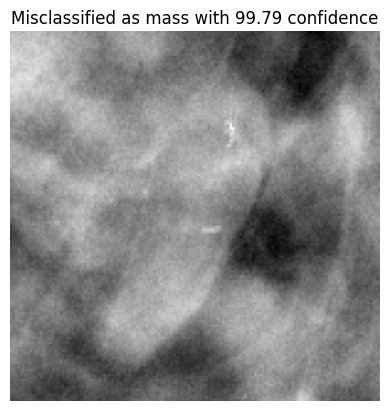

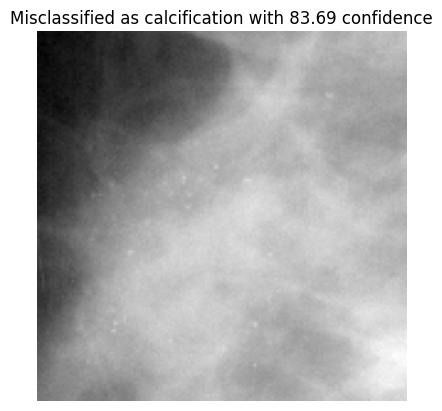

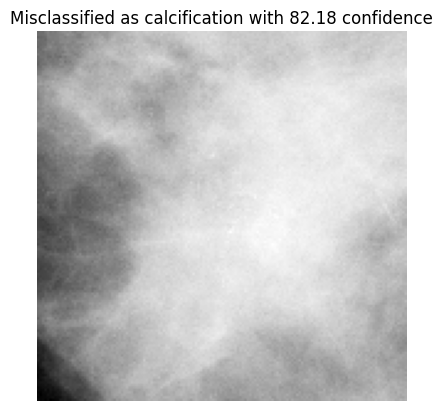

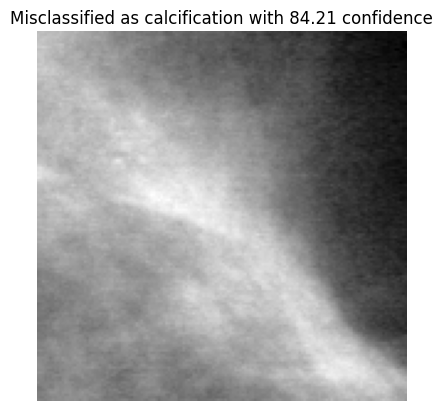

In [ ]:
show_error_stats(errors_9, mispred_9, hard_mispred_9)

In [ ]:
correct_5 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_5), test_labels)])
correct_6 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_6), test_labels)])
correct_9 = np.array([abs(p-l) < 0.5 for p,l in zip(np.squeeze(pred_9), test_labels)])

wrong_5 = np.logical_not(correct_5)
wrong_6 = np.logical_not(correct_6)
wrong_9 = np.logical_not(correct_9)

hard_wrong_5 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_5), test_labels)])
hard_wrong_6 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_6), test_labels)])
hard_wrong_9 = np.array([abs(p-l) > 0.8 for p,l in zip(np.squeeze(pred_9), test_labels)])

differ_5_6 = np.logical_xor(correct_5, correct_6)
differ_5_9 = np.logical_xor(correct_5, correct_9)
differ_6_9 = np.logical_xor(correct_6, correct_9)

wrong_all = np.logical_and(wrong_5, wrong_6, wrong_9)
hard_wrong_all = np.logical_and(hard_wrong_5, hard_wrong_6, hard_wrong_9)

In [ ]:
print("5 and 6 differ for %d samples" % np.sum(differ_5_6))
print("5 and 9 differ for %d samples" % np.sum(differ_5_9))
print("6 and 9 differ for %d samples" % np.sum(differ_6_9))

print("%d samples were misclassified by all three" % np.sum(wrong_all))
print("%d samples were hard misclassified by all three" % np.sum(hard_wrong_all))

5 and 6 differ for 31 samples
5 and 9 differ for 22 samples
6 and 9 differ for 25 samples
32 samples were misclassified by all three
11 samples were hard misclassified by all three


In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

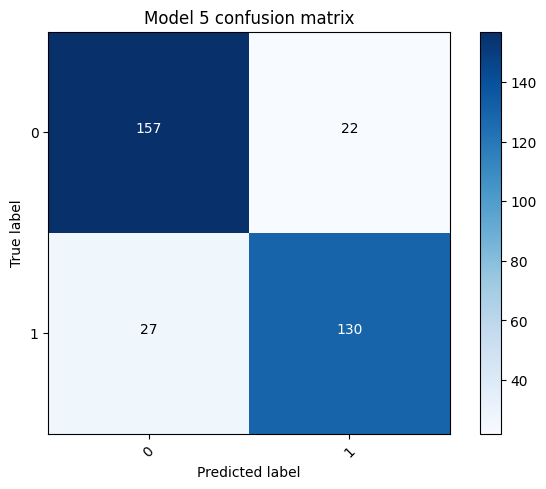

In [ ]:
pred_5_classes = np.rint(pred_5)
confusion_mtx = confusion_matrix(test_labels, pred_5_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 5 confusion matrix')

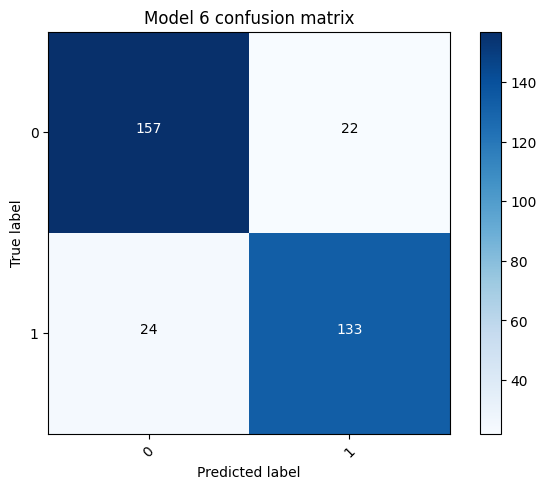

In [ ]:
pred_6_classes = np.rint(pred_6)
confusion_mtx = confusion_matrix(test_labels, pred_6_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 6 confusion matrix')

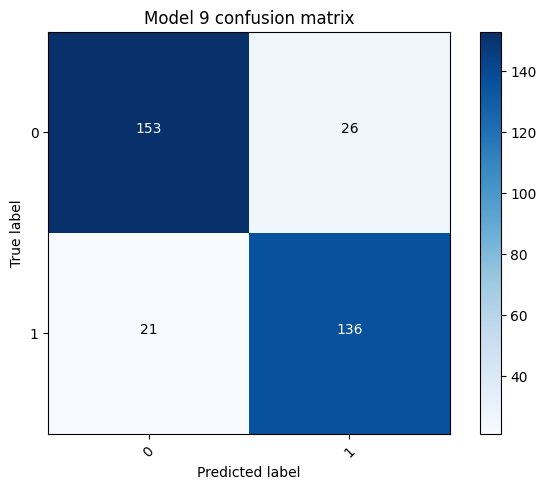

In [ ]:
pred_9_classes = np.rint(pred_9)
confusion_mtx = confusion_matrix(test_labels, pred_9_classes)
plot_confusion_matrix(confusion_mtx, classes = range(2), normalize=False, title='Model 9 confusion matrix')

In [ ]:
def plot_roc(preds, names, titles='ROC curve'):
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    for pred, name in zip(preds, names):
        fpr, tpr, _ = roc_curve(test_labels, pred)
        auc_keras = auc(fpr, tpr)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=(name +' (area = {:.3f})'.format(auc_keras)))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()

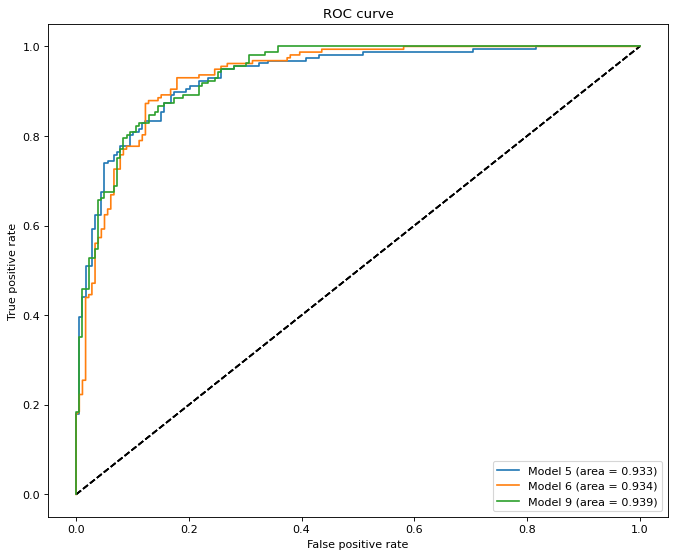

In [ ]:
plot_roc([pred_5, pred_6, pred_9], names=['Model 5', 'Model 6', 'Model 9'])